In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.datasets import daocensus_text
import src.utils.notebooks as nbutils

sns.set_theme()
plt.rcParams['figure.dpi'] = 600

In [2]:
# 'ORG_NAME', 'ORG_PLATFORM', 'SPLITS_FREQ', 'SPLITS_NORMALIZE', 'LAST_SPLITS', 'USE_ORG_NAMES'

ORG_NAME = 'gm DAO'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES = True

# Not used
SPLITS_FREQ = ...
SPLITS_NORMALIZE = ...
LAST_SPLITS = ...
CUTOFF_DATE_STR = ...

In [3]:
# Parameters
ORG_NAME = "PancakeSwap"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-01 21:00"
CUTOFF_DATE_STR = "2023-07-07"


In [4]:
dfv, dfp = daocensus_text.get('./data/daos-census-text', ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 532830 votes without proposal


<class 'pandas.core.frame.DataFrame'>
Int64Index: 532830 entries, 0 to 532829
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       532830 non-null  object        
 1   name           532830 non-null  object        
 2   id             532830 non-null  object        
 3   proposal       532830 non-null  category      
 4   deployment     532830 non-null  object        
 5   platform_vote  532830 non-null  object        
 6   voter          532830 non-null  category      
 7   date           532830 non-null  datetime64[ns]
 8   choice         532830 non-null  object        
 9   weight         532830 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 40.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 2693 entries, b771e498-0ba7-5c86-a10a-ab643c7c7d96 to c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe
Data columns (total 12 colum

# Exploración de datos de Decentraland

In [5]:
print(f"{ORG_NAME} tiene {len(dfv)} votos de {dfv['voter'].nunique()} voters en {dfv['proposal'].nunique()} propuestas")

PancakeSwap tiene 532830 votos de 129978 voters en 2691 propuestas


In [6]:
dfd = dfp[['platform', 'name', 'platform_deployment']].drop_duplicates()
dfd

platform         name  \
id                                                            
b771e498-0ba7-5c86-a10a-ab643c7c7d96  snapshot  PancakeSwap   

                                     platform_deployment  
id                                                        
b771e498-0ba7-5c86-a10a-ab643c7c7d96        cakevote.eth

## Histograma de votos por usuario

129978
502
count    129978.000000
mean          4.099386
std          14.785008
min           1.000000
50%           1.000000
90%           7.000000
95%          14.000000
99%          55.000000
max        1111.000000
dtype: float64


Cannot show ipywidgets in text

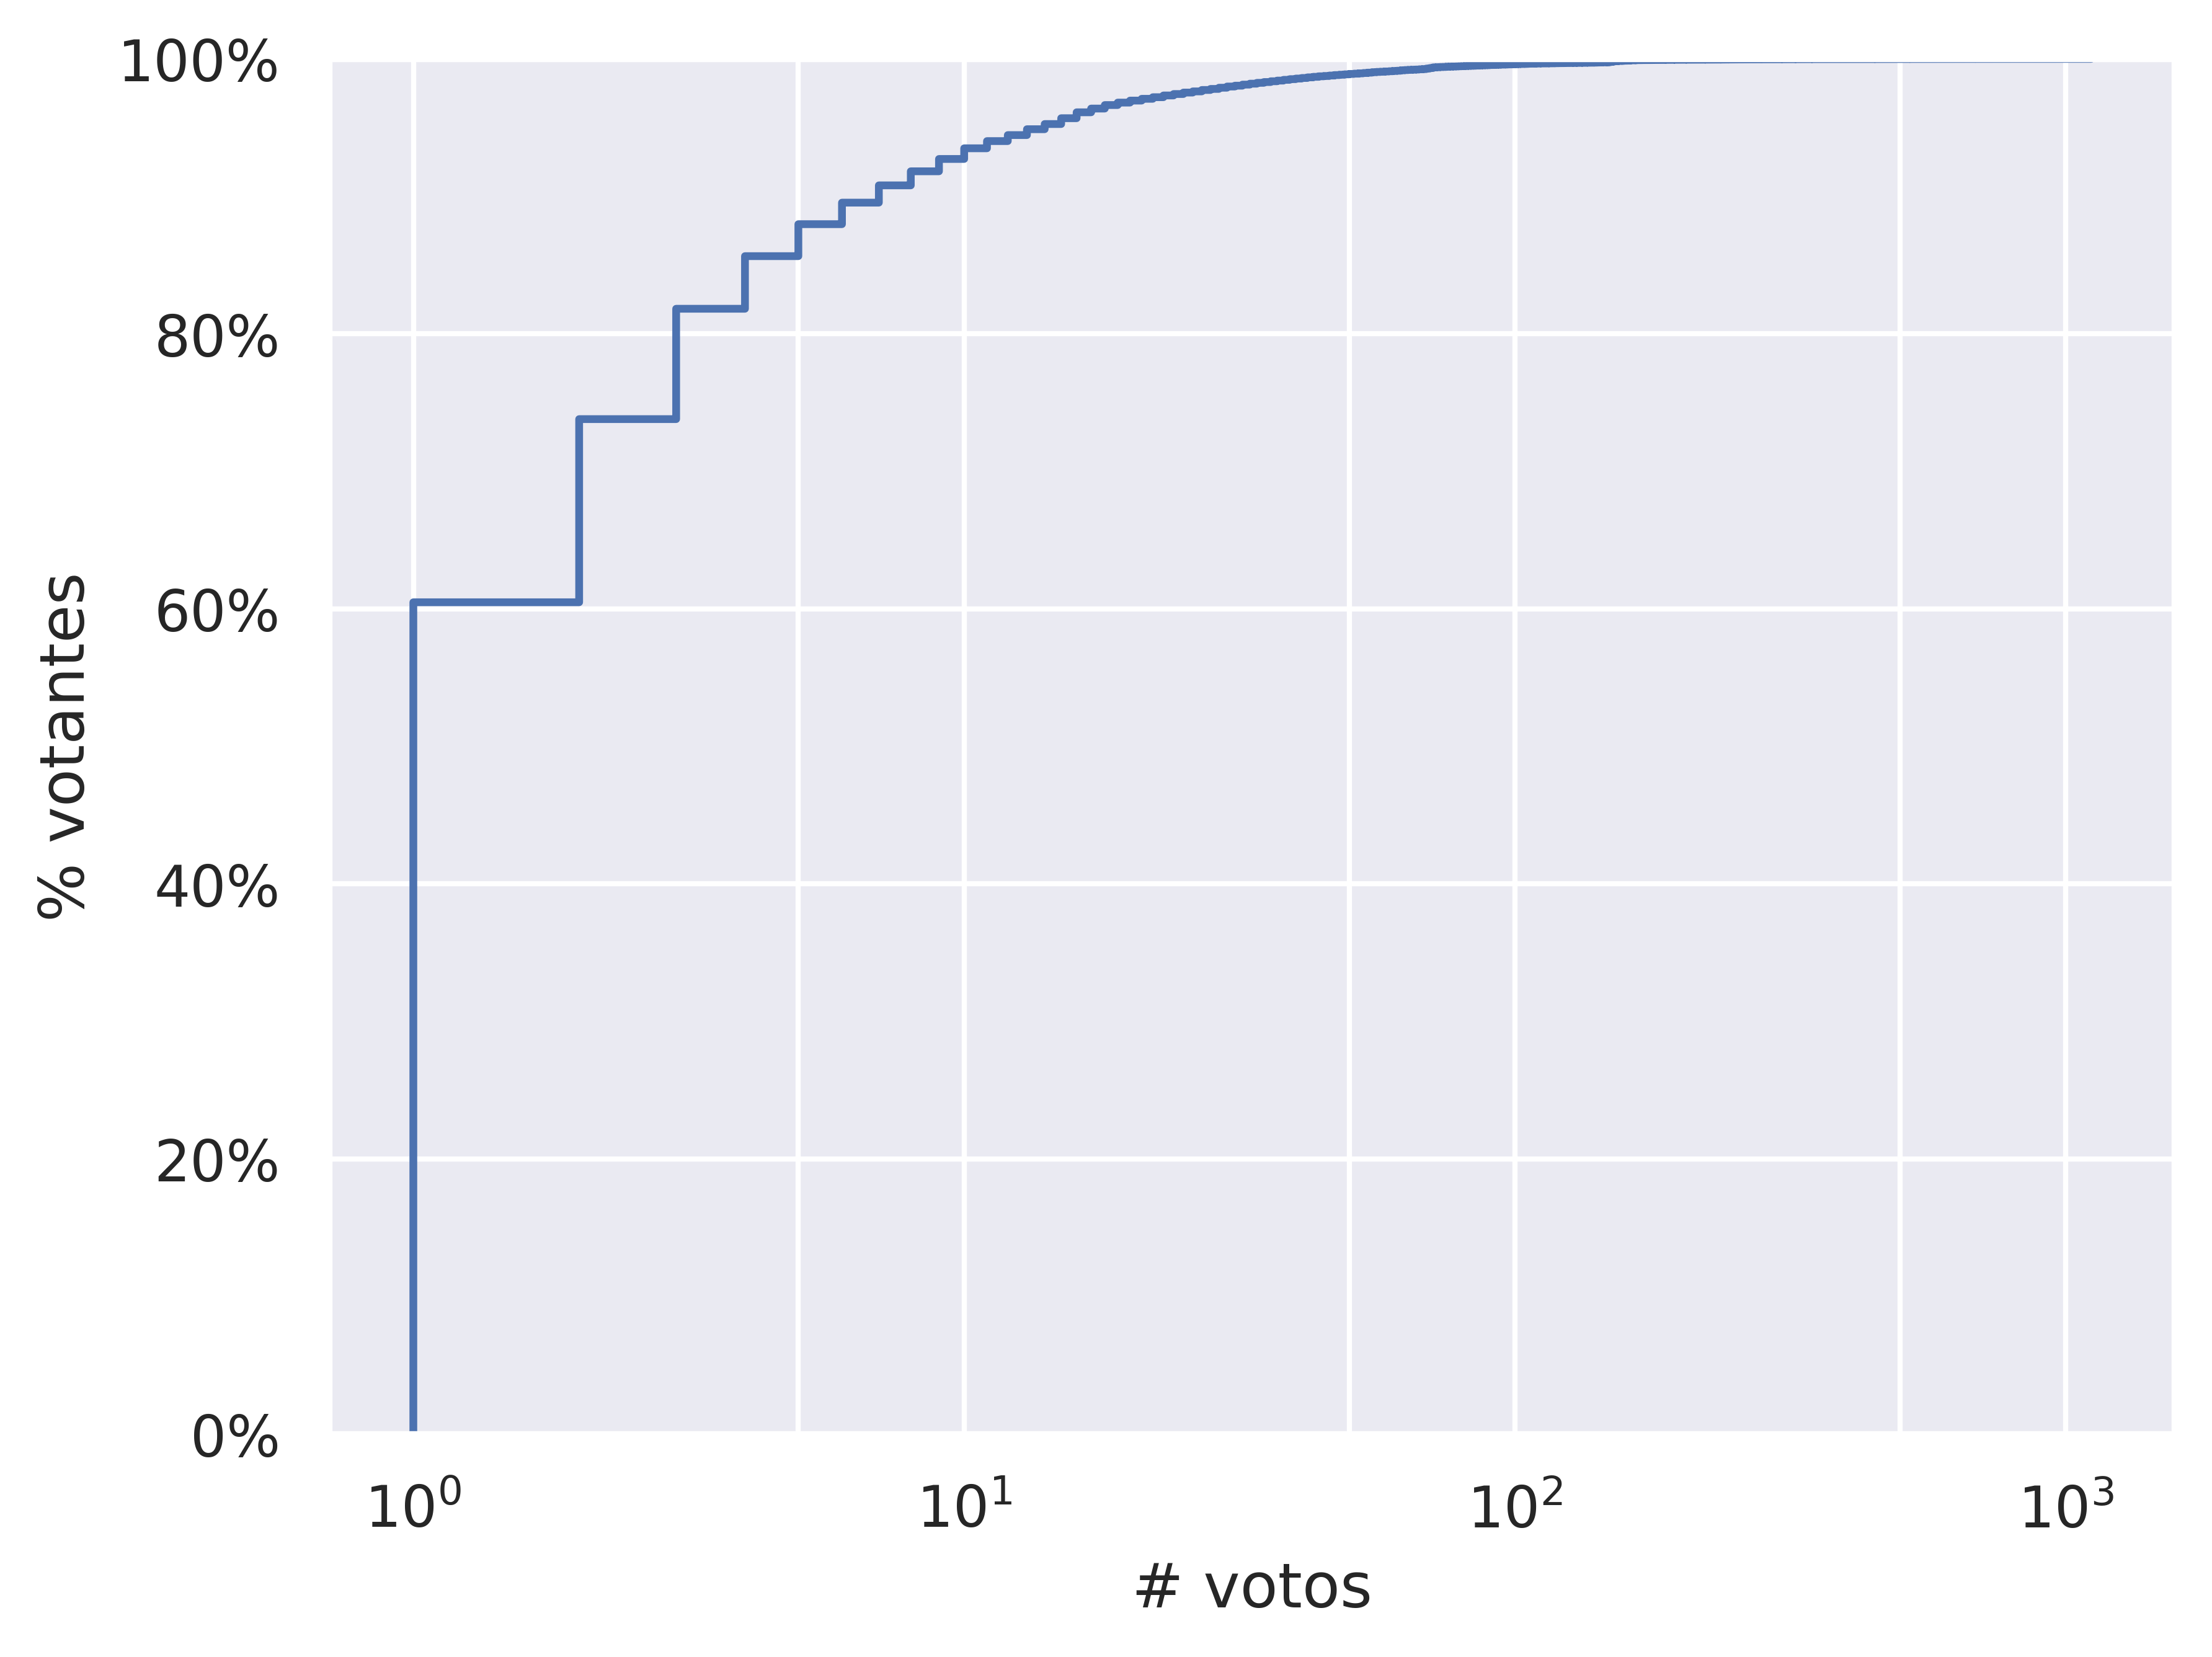

In [7]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print( len(_toplot) )
print( (_toplot > 100).sum() )
print(_toplot.describe(percentiles=[.5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votos')
plt.ylabel('% votantes')

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_voters_{ORG_NAME}.pdf')

## Histograma de votos por propuesta

count    2693.000000
mean      194.721129
std       426.651323
min         1.000000
50%        61.000000
75%       163.000000
90%       523.800000
95%       830.600000
99%      1877.960000
max      8888.000000
Name: votes_count, dtype: float64
448


Cannot show ipywidgets in text

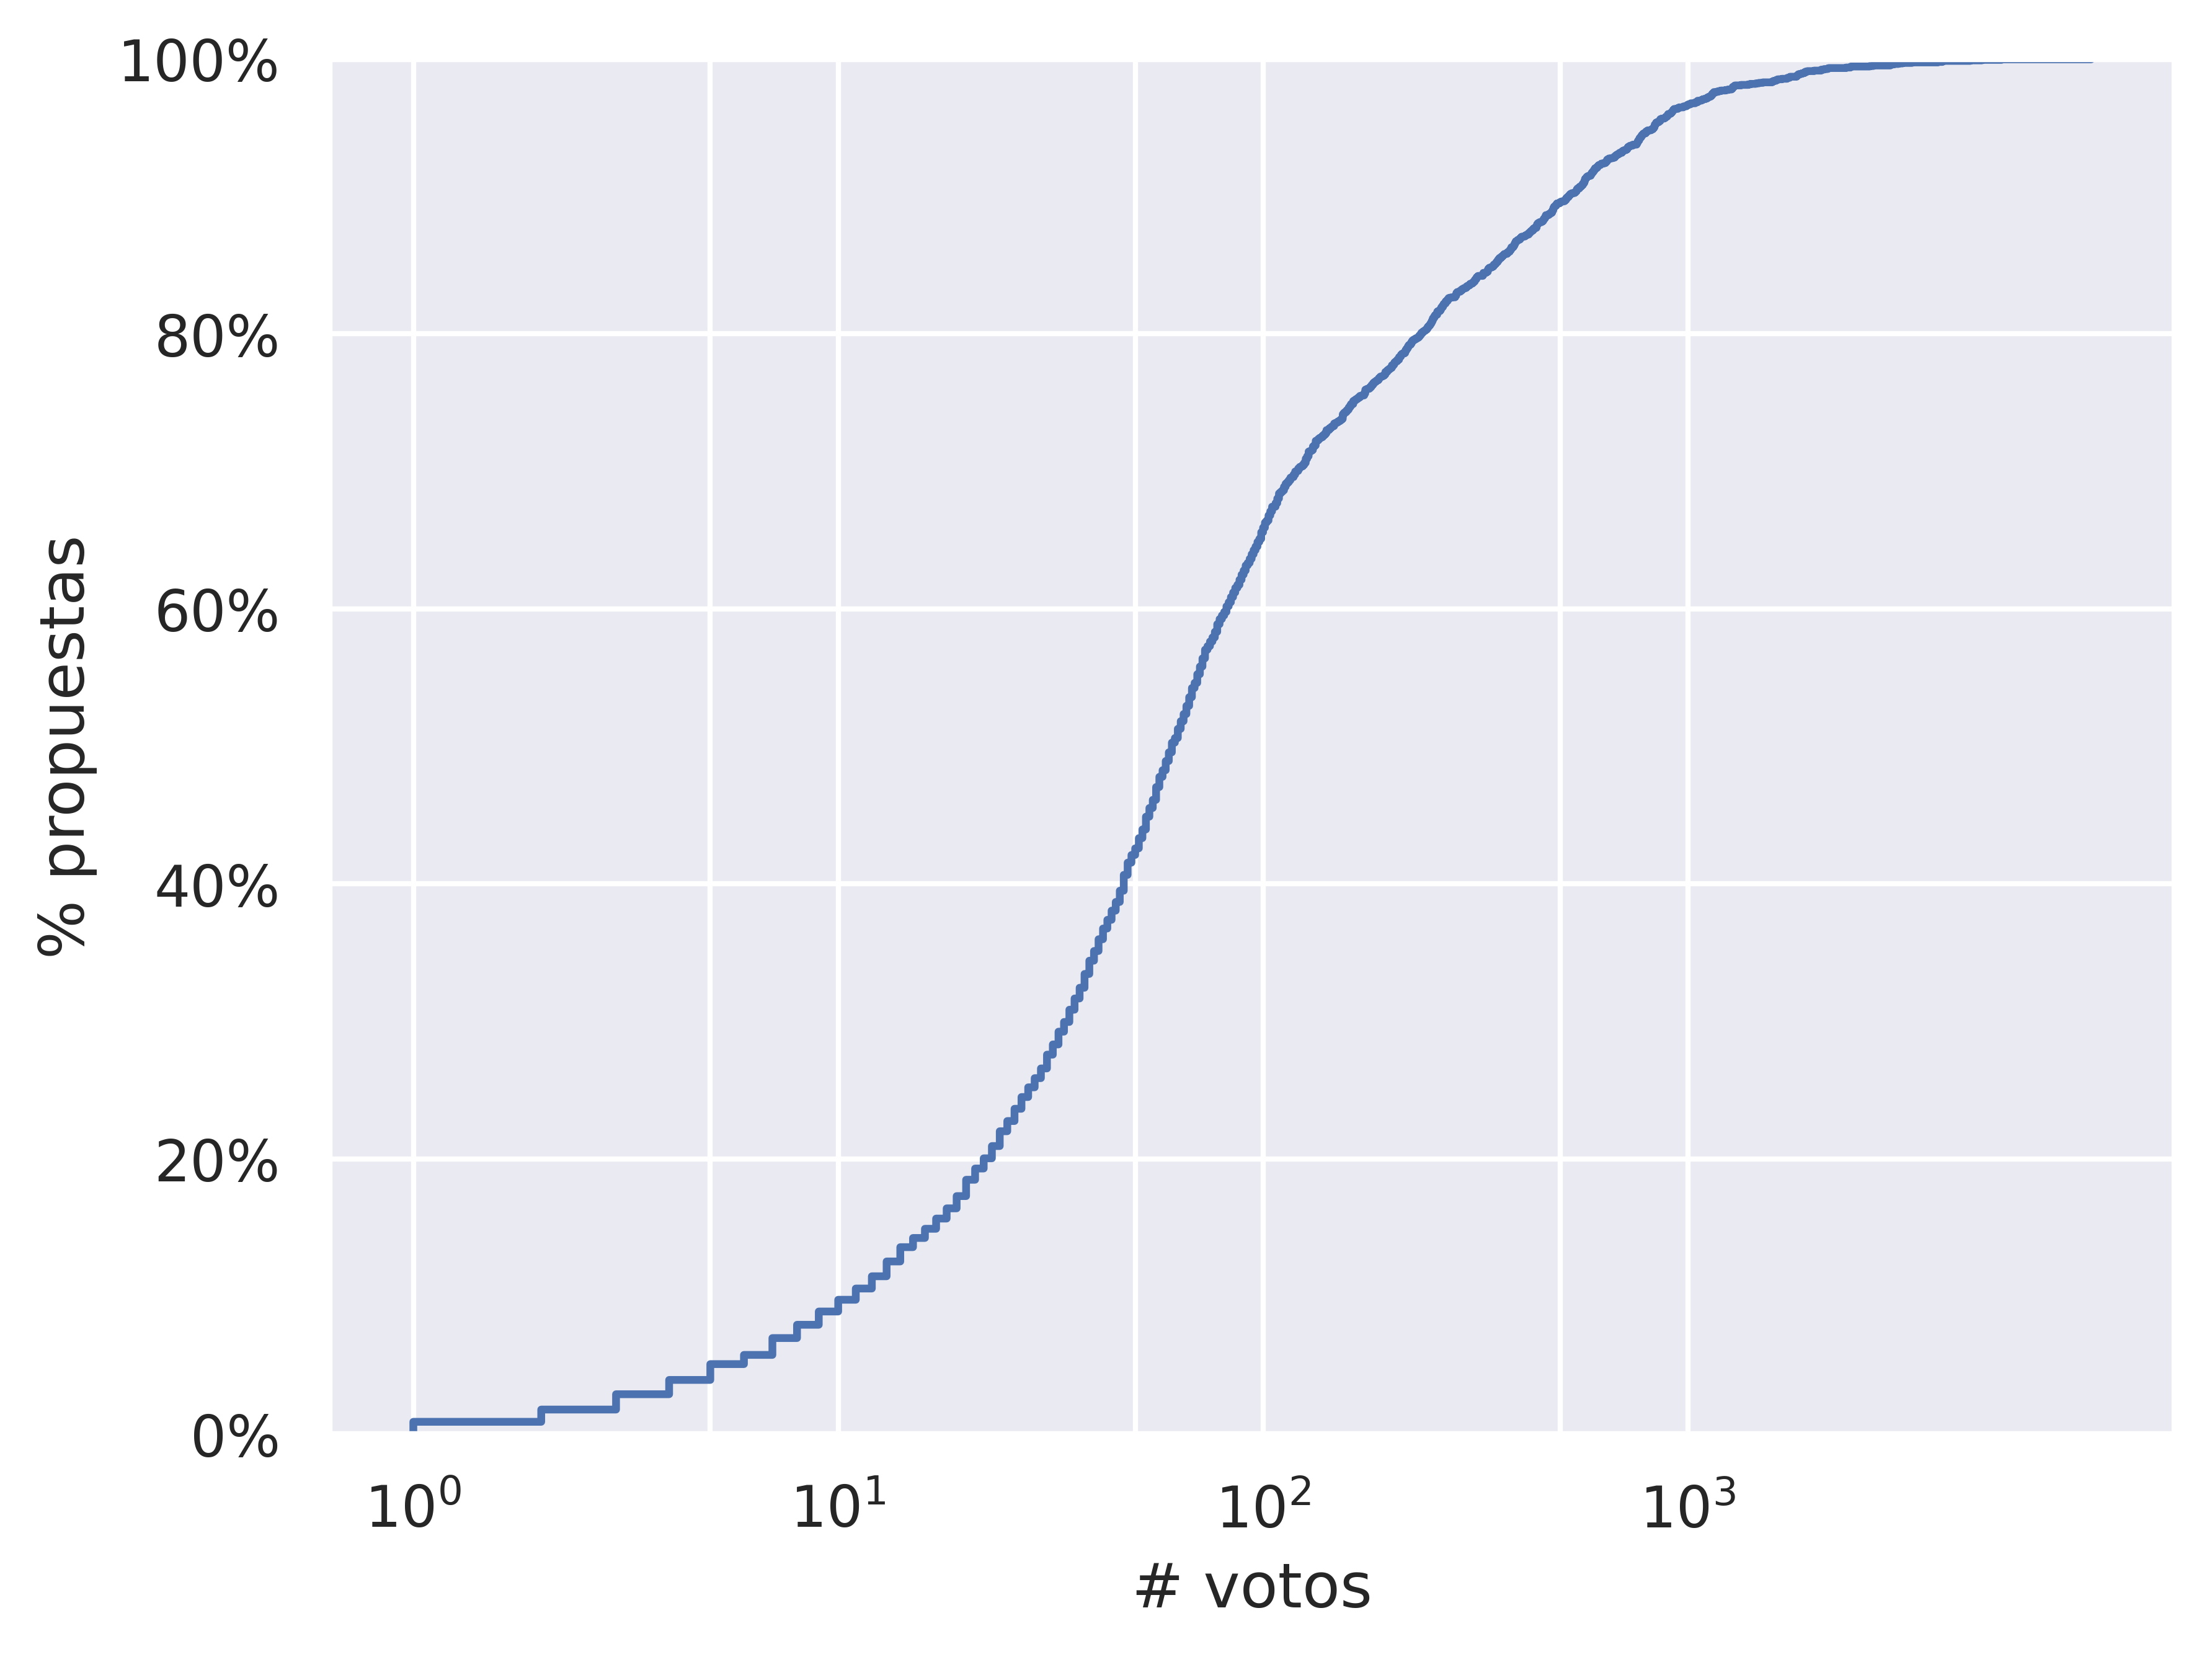

In [8]:
_toplot = dfp['votes_count']
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.xlabel('# votos')
plt.ylabel('% propuestas')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_proposals_{ORG_NAME}.pdf')

count    2691.000000
mean      198.004459
std       430.256276
min         1.000000
50%        61.000000
75%       167.500000
90%       540.000000
95%       835.000000
99%      1889.100000
max      8888.000000
dtype: float64
460


<Axes: ylabel='Proportion'>

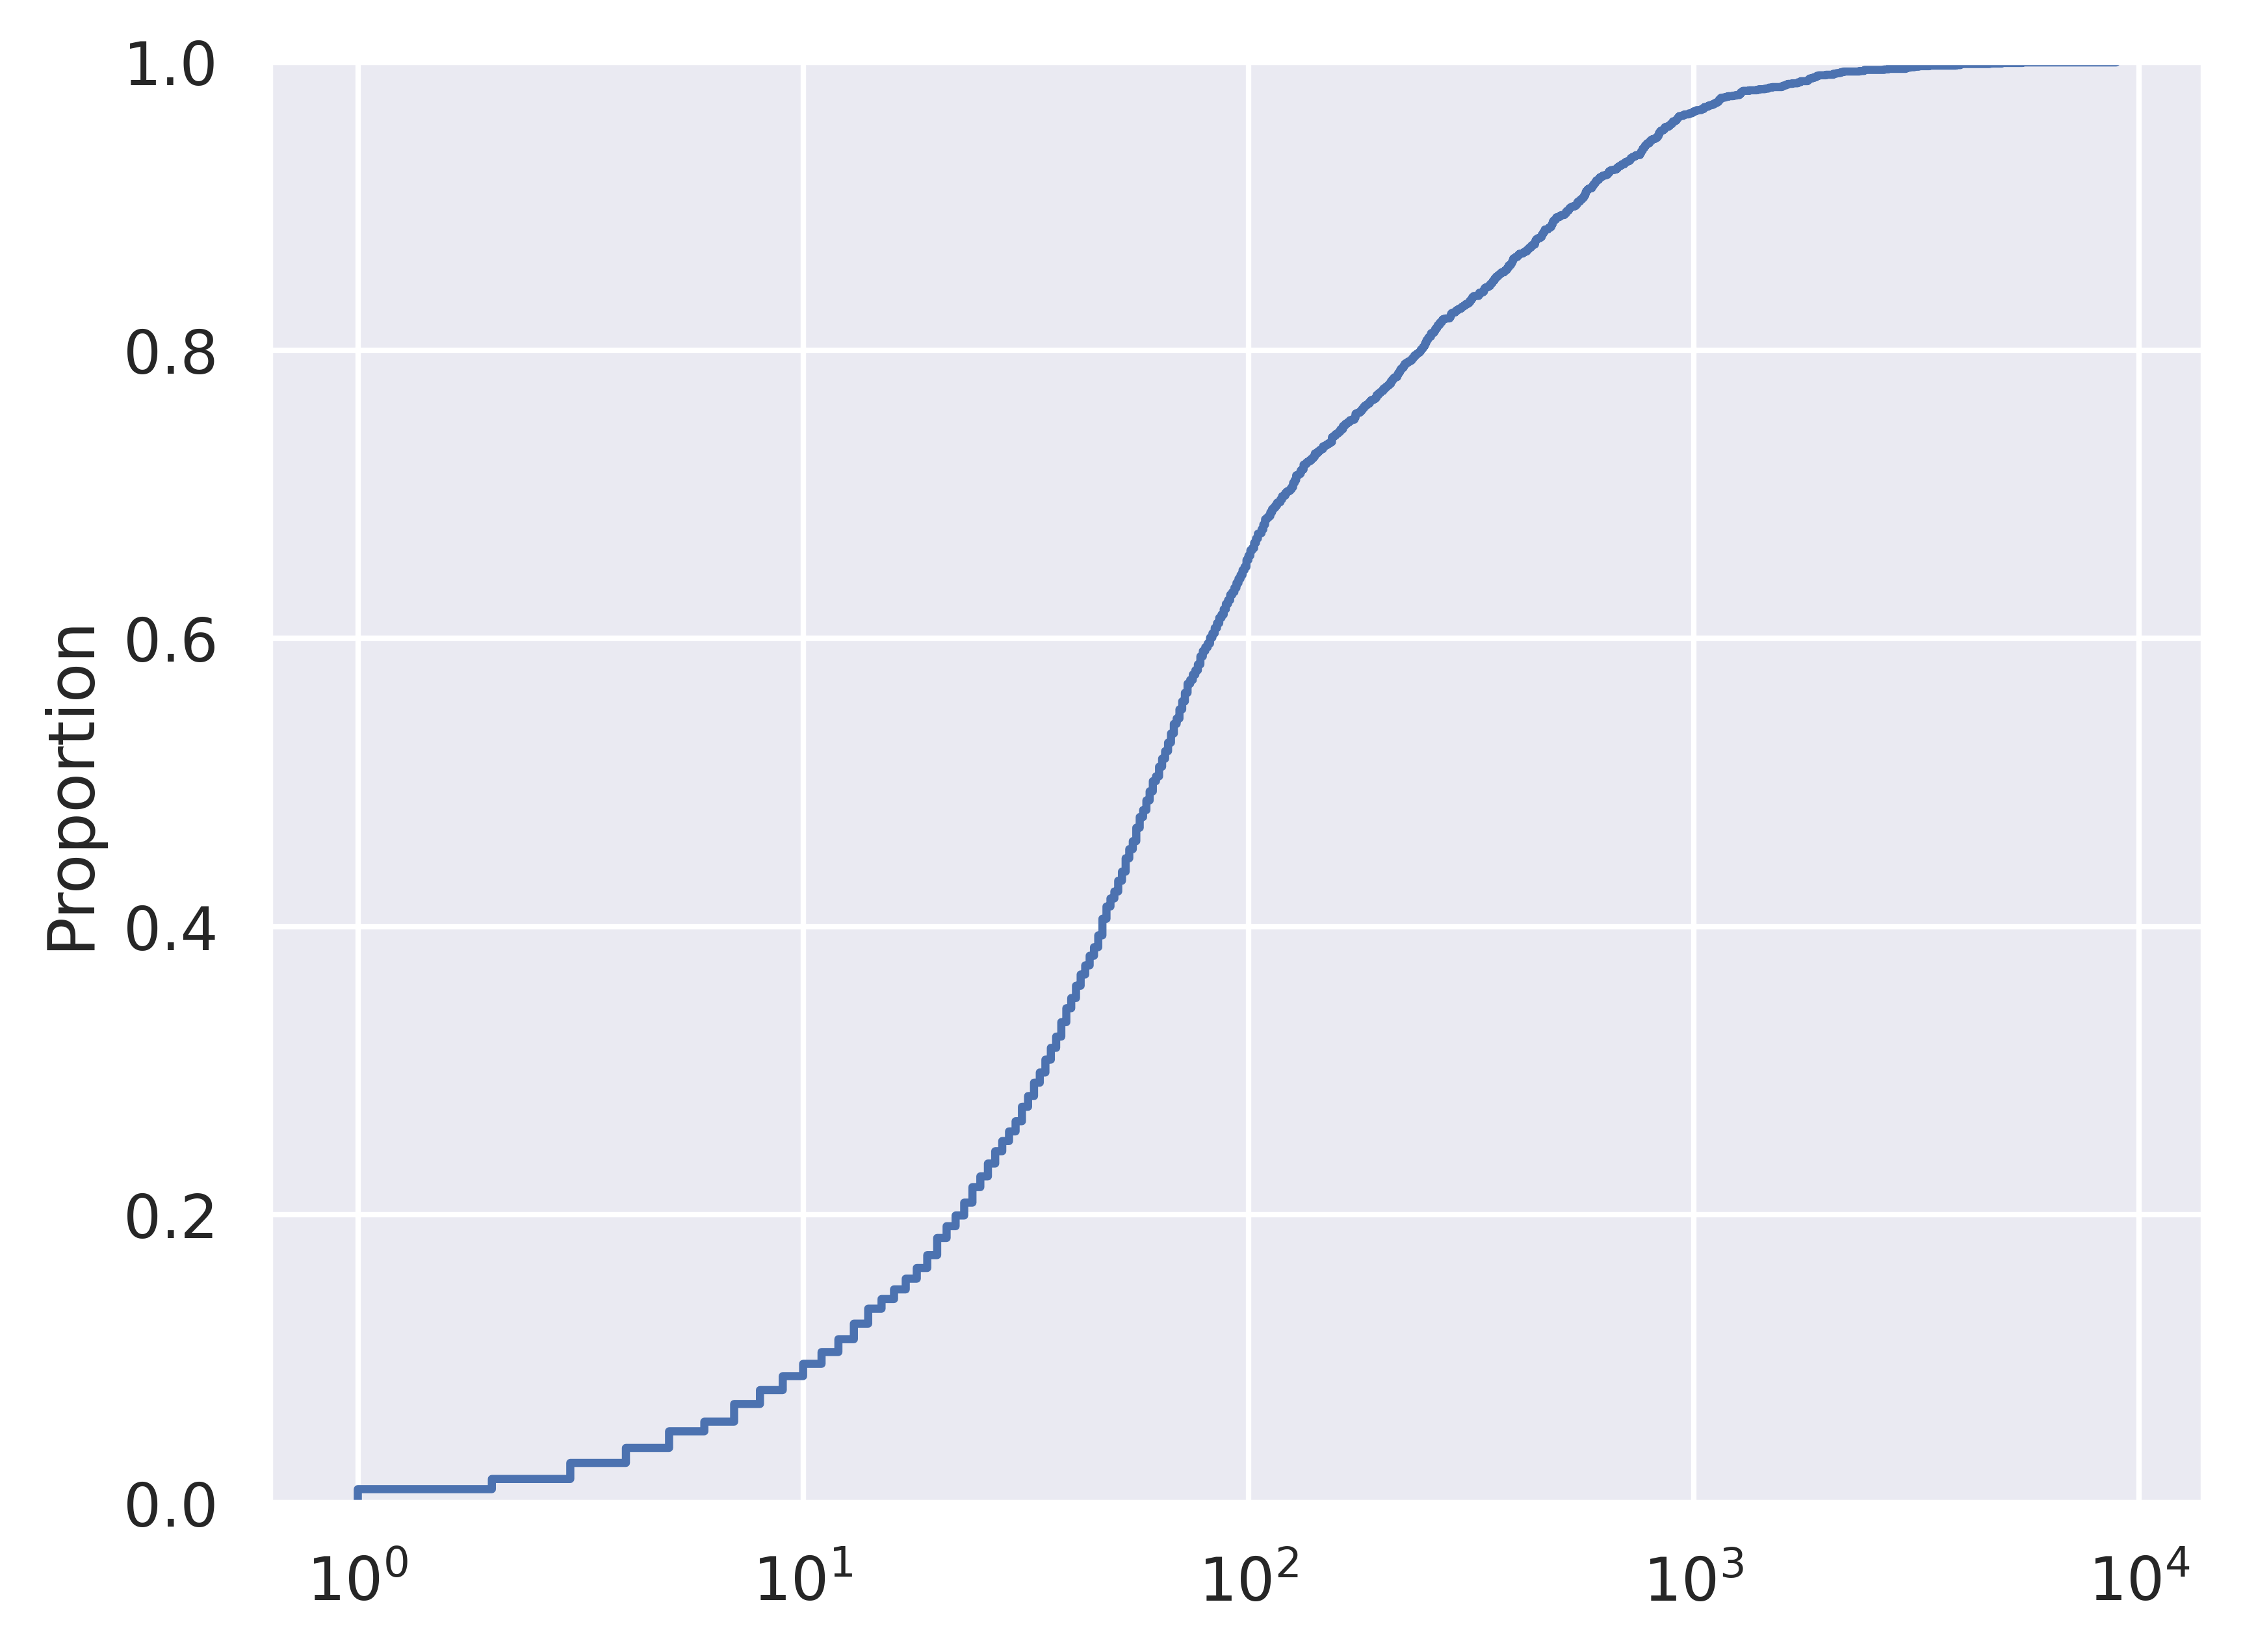

In [9]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )
sns.ecdfplot(_toplot, log_scale=True)

### Usuarios activos

In [10]:
# dfv.set_index('date').sort_index()['voter'].tolist()
# for x in dfv.set_index('date').sort_index()['voter'].items():
#     print(x)

/tmp/ipykernel_324908/3928196604.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/532830 [00:00<?, ?it/s]

2021-06-28 12:14:46 2023-07-20 03:54:45


Cannot show ipywidgets in text

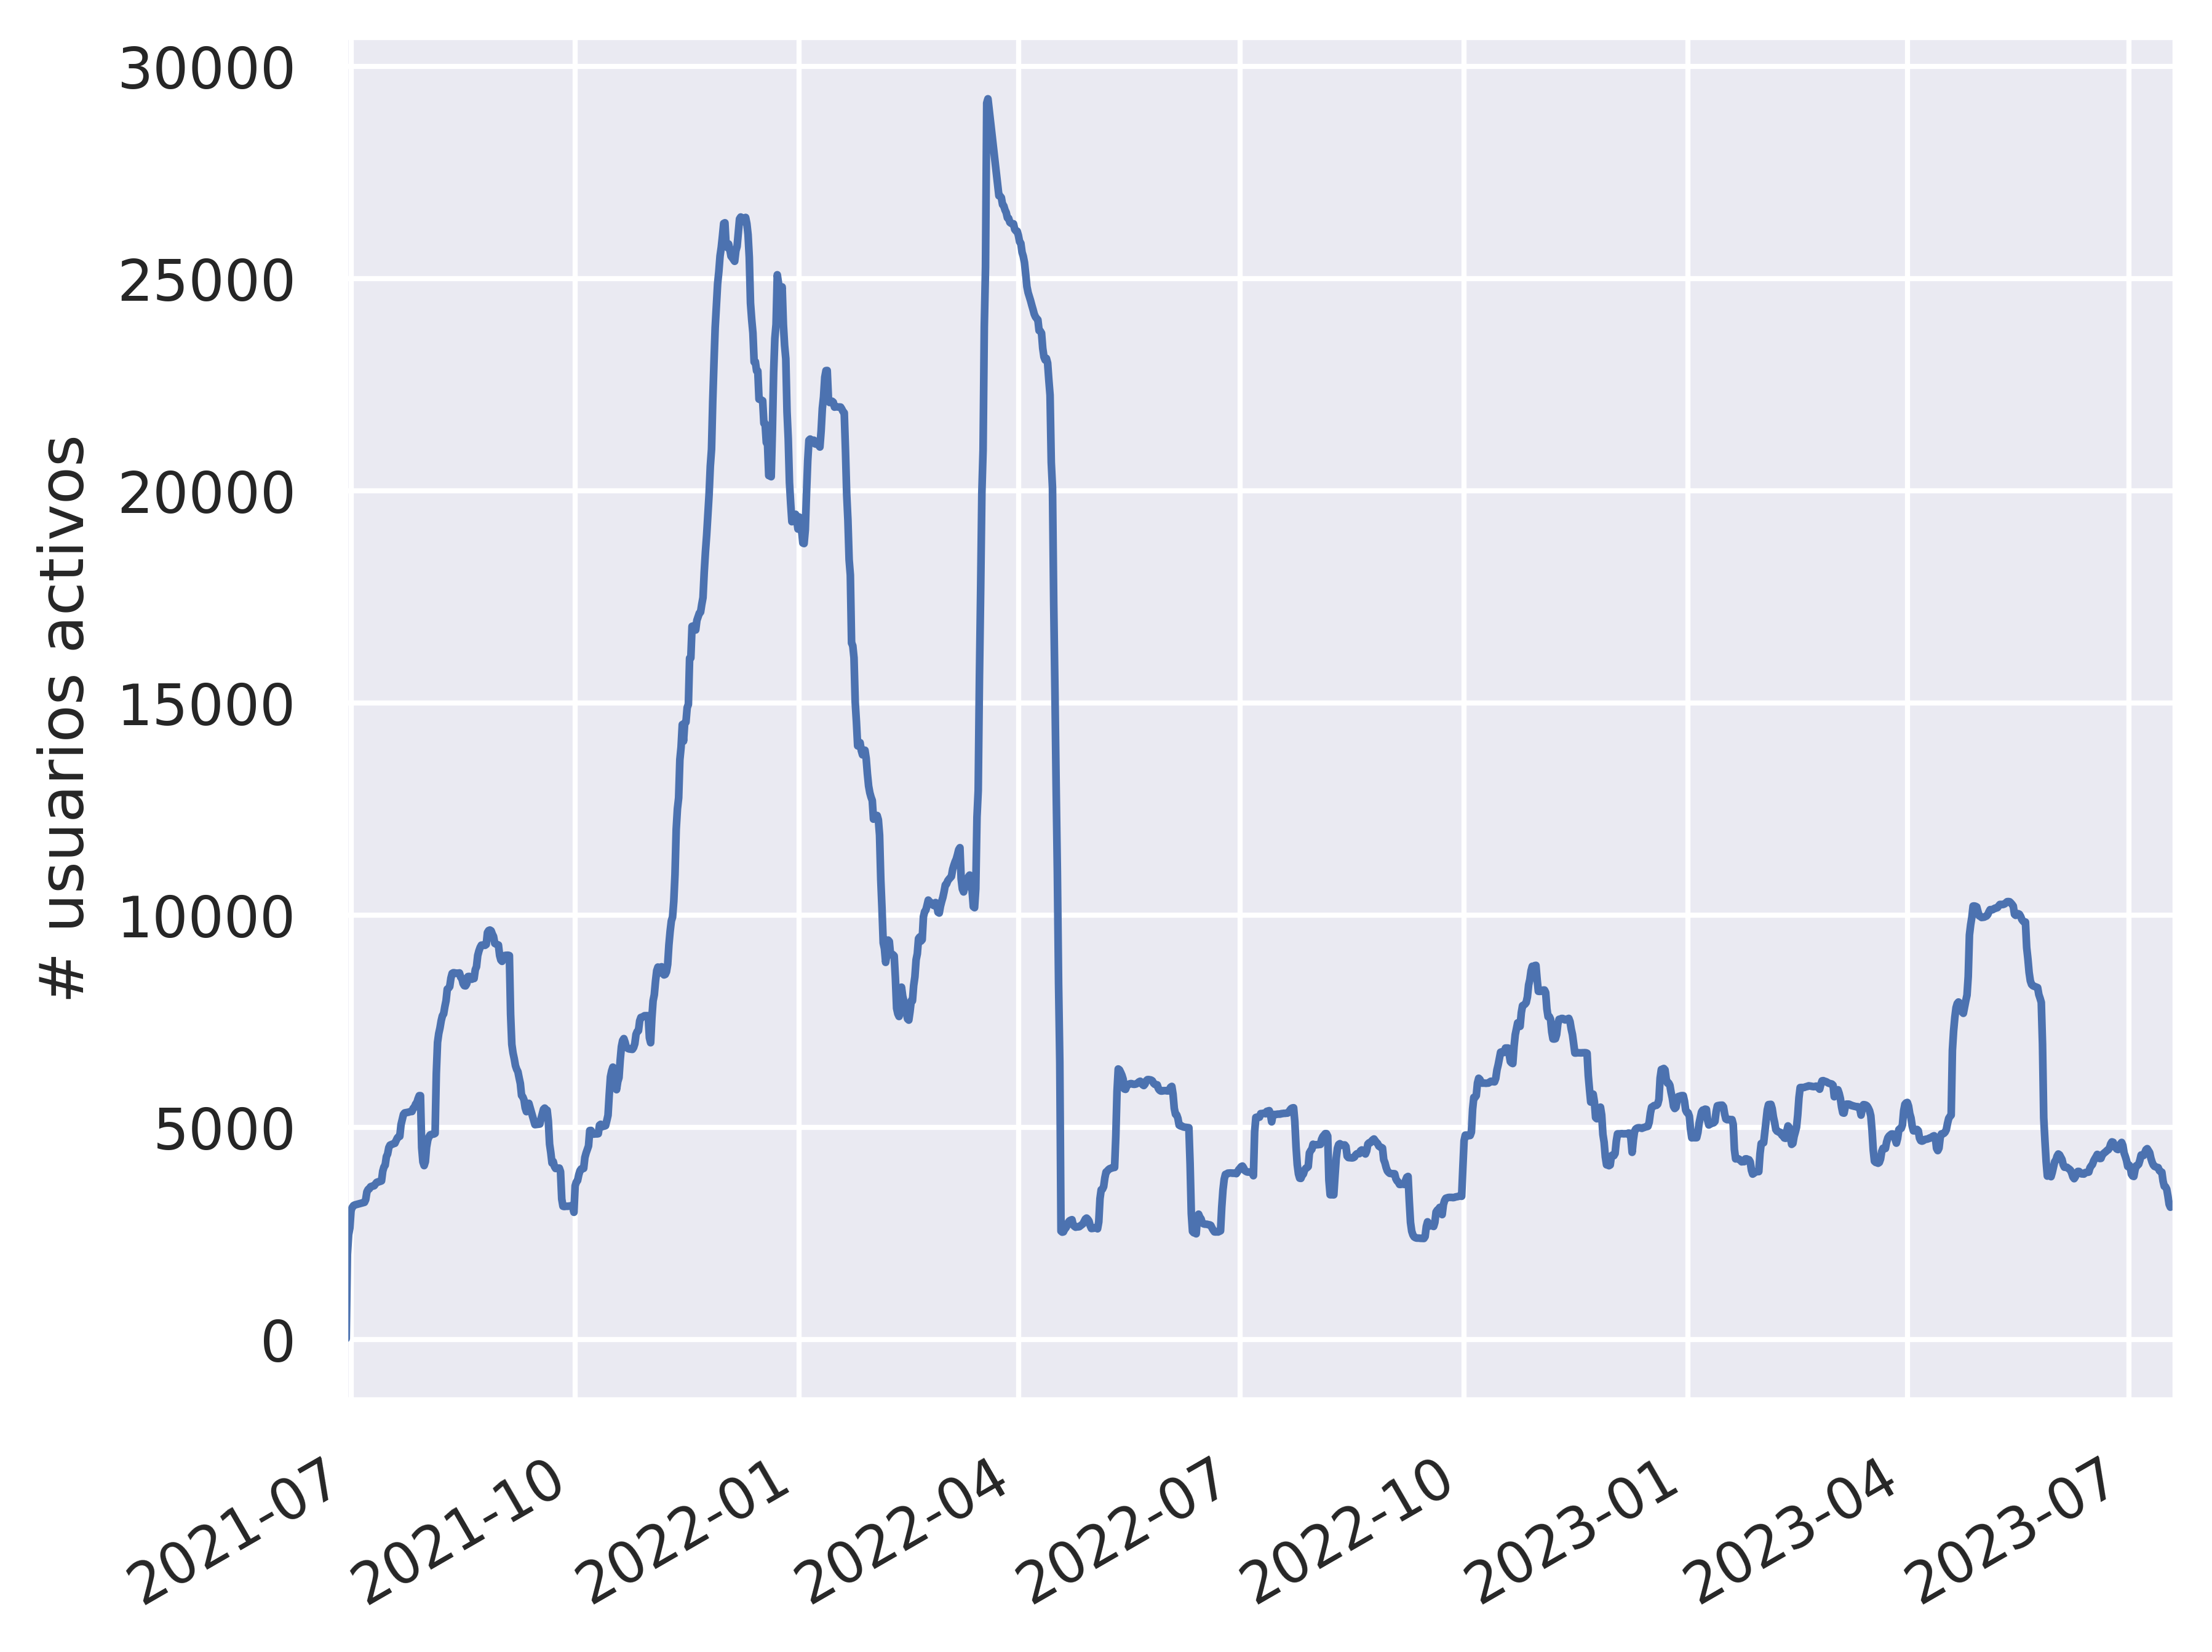

In [11]:
# import numba
from tqdm.autonotebook import tqdm
import rolling
import datetime as dt

tqdm.pandas(total=len(dfv))

# WINDOW_SIZE = '30D'
WINDOW_SIZE = dt.timedelta(days=30)

RESAMPLE_FREQ = '12h'

# @numba.jit(nopython=True)
# def nunique(arr):
#     return len(set(arr))

# Rolling no acepta tipos no númericos en la agregación, por lo que es necesario convertir la categoría a entero
# Por ejemplo, usando el código que le asigna Pandas
# dfv['ucode'] = dfv['voter'].cat.codes
#_cnt = dfv.set_index('date').sort_index().rolling(WINDOW_SIZE)['ucode'].progress_apply(nunique, raw=True).rename('cnt')

# Al final resulta que lo mejor era ir a por la solución O(1)
_voters = dfv.set_index('date').sort_index()['voter'] # .cat.codes
r = tqdm(
    rolling.arithmetic.Nunique(_voters.items(), WINDOW_SIZE, window_type='indexed'),
    total=len(dfv),
)
_cnt = pd.Series(r, index=_voters.index)
# Need to resample or there would be too many points
_cnt = _cnt.resample(RESAMPLE_FREQ).max()

print(dfv['date'].min(), dfv['date'].max())
ax = sns.lineplot(_cnt)
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# usuarios activos')
plt.xlim(dfv['date'].min(), dfv['date'].max())
nbutils.download_matplotlib(ax.figure, f'04c_rolling_voters_{WINDOW_SIZE}_{ORG_NAME}.png')

## Cuando se unen los usuarios

Es decir, cuando votan por primera vez

Cannot show ipywidgets in text

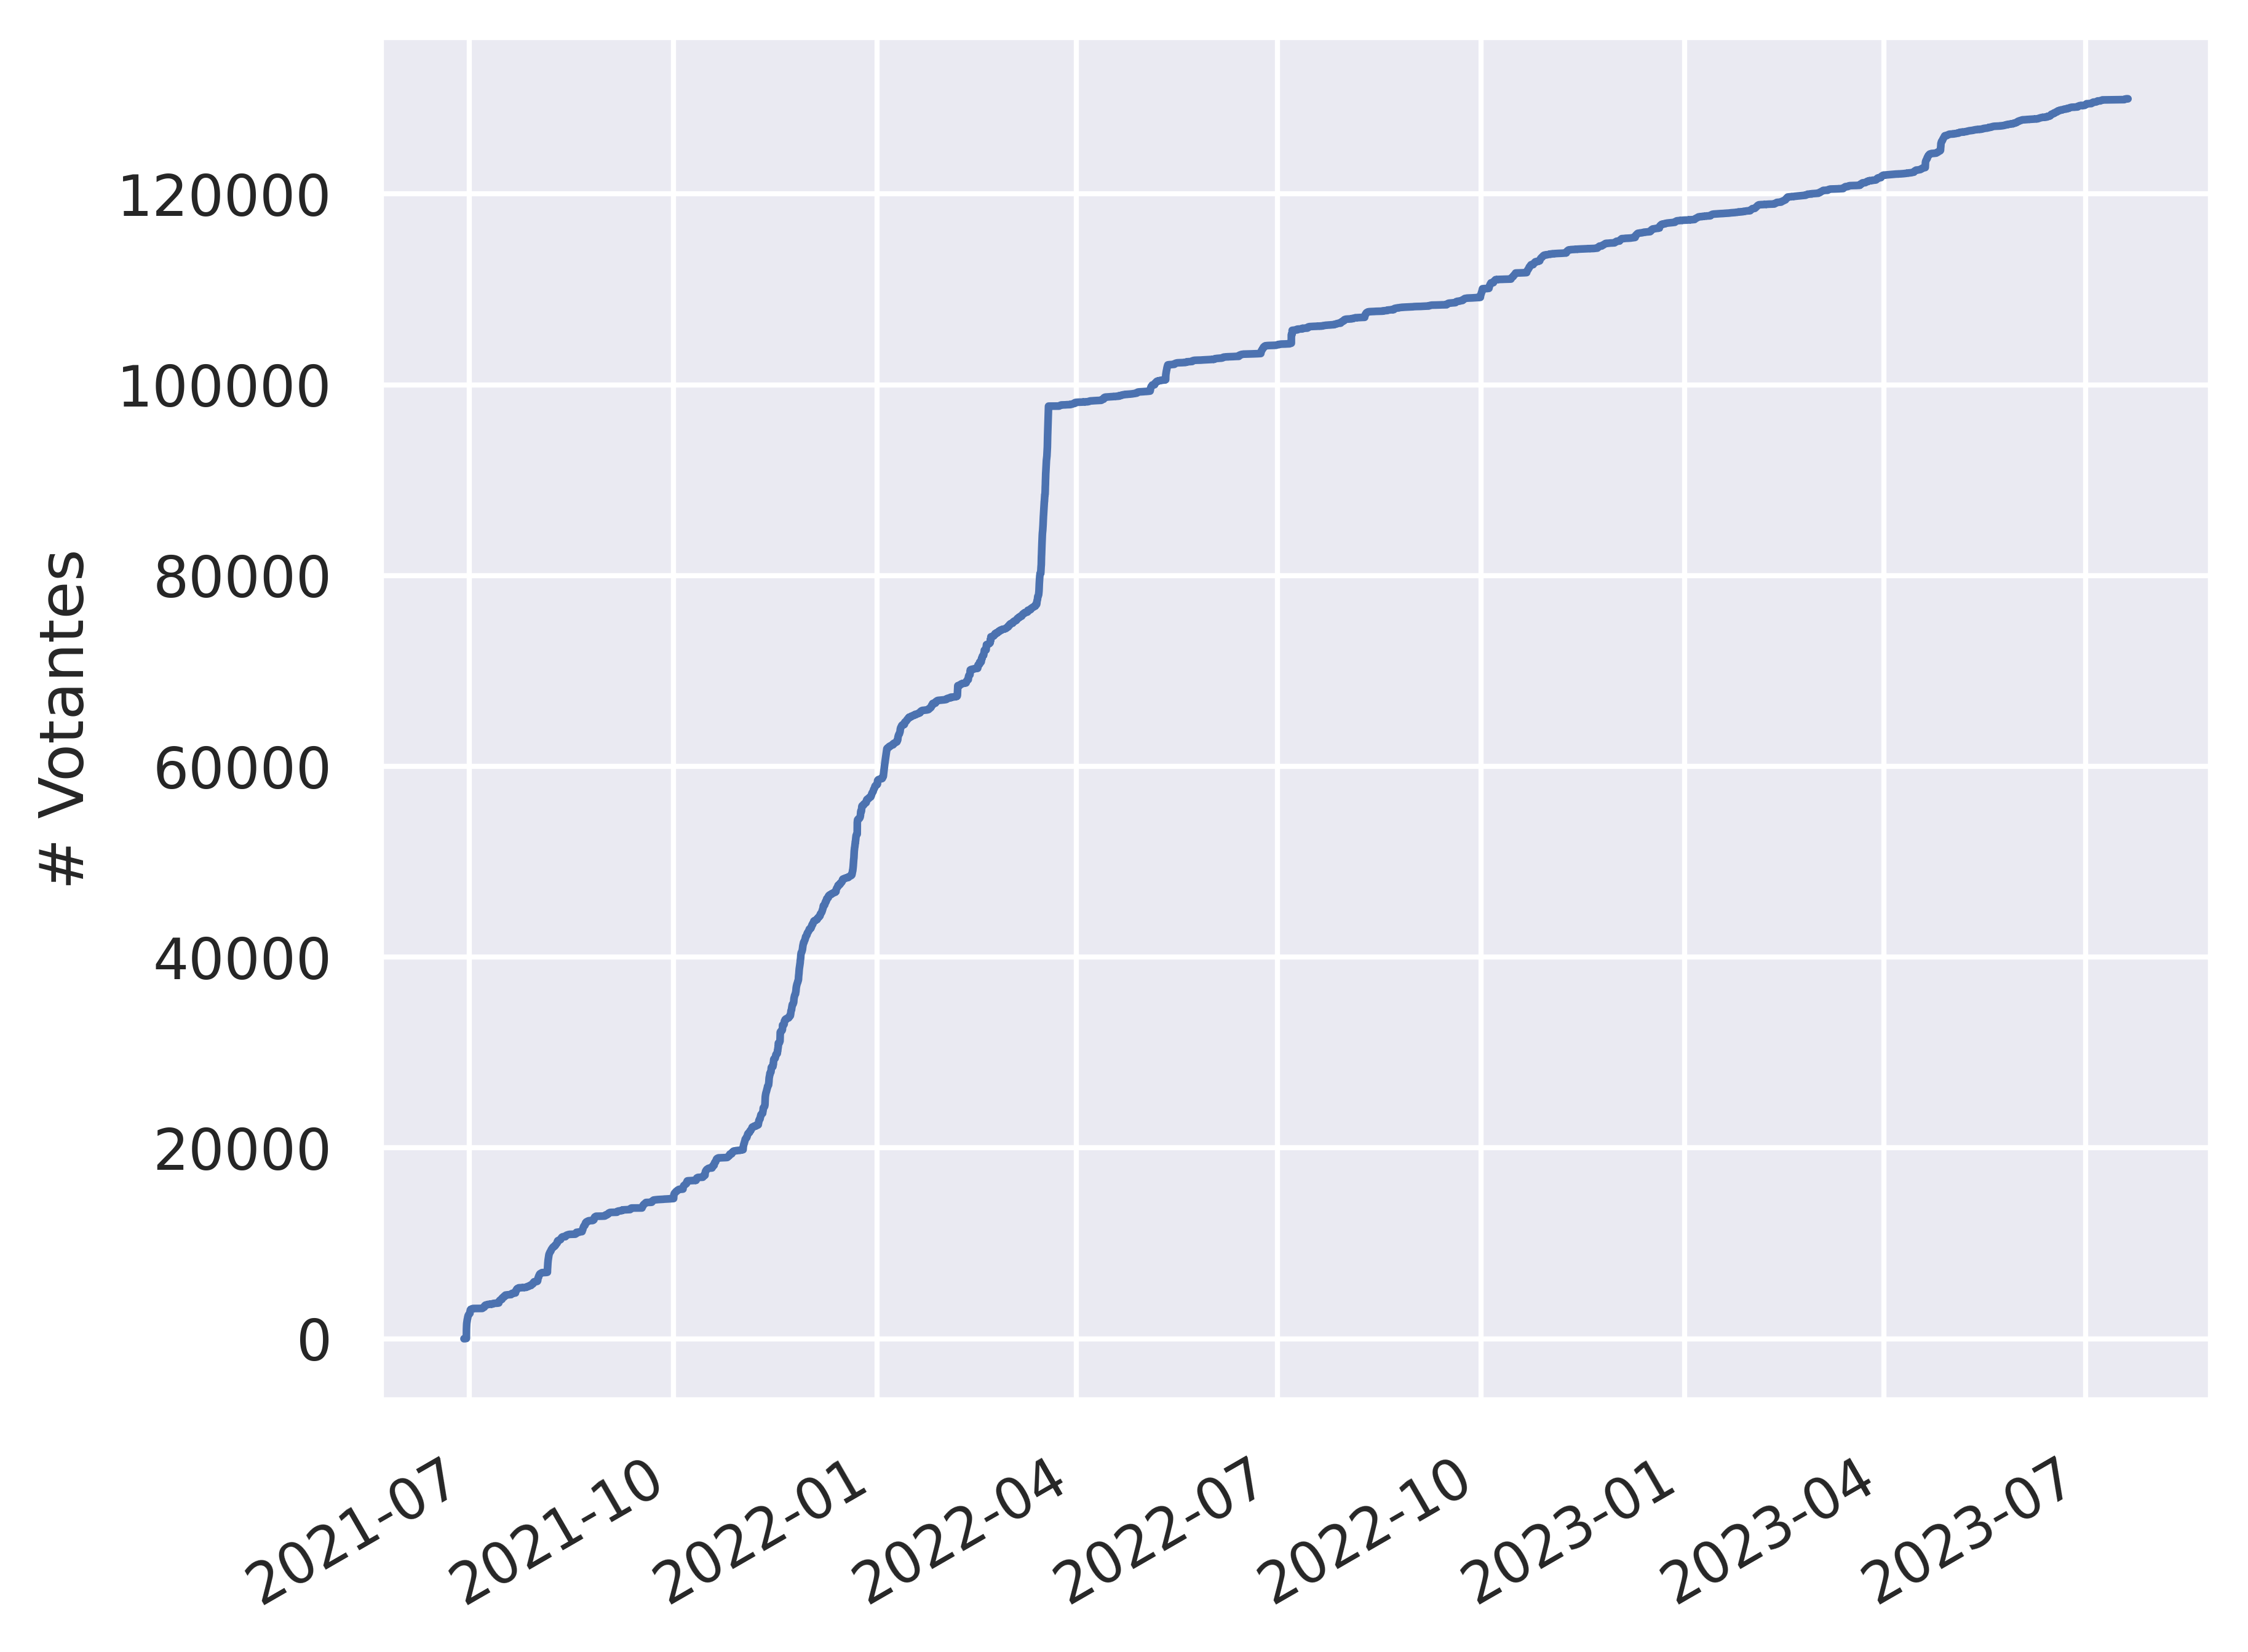

In [12]:
_toplot = dfv.groupby('voter')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Votantes')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_cumcnt_users_{ORG_NAME}.pdf')

## Cuando se crean las propuestas

Cannot show ipywidgets in text

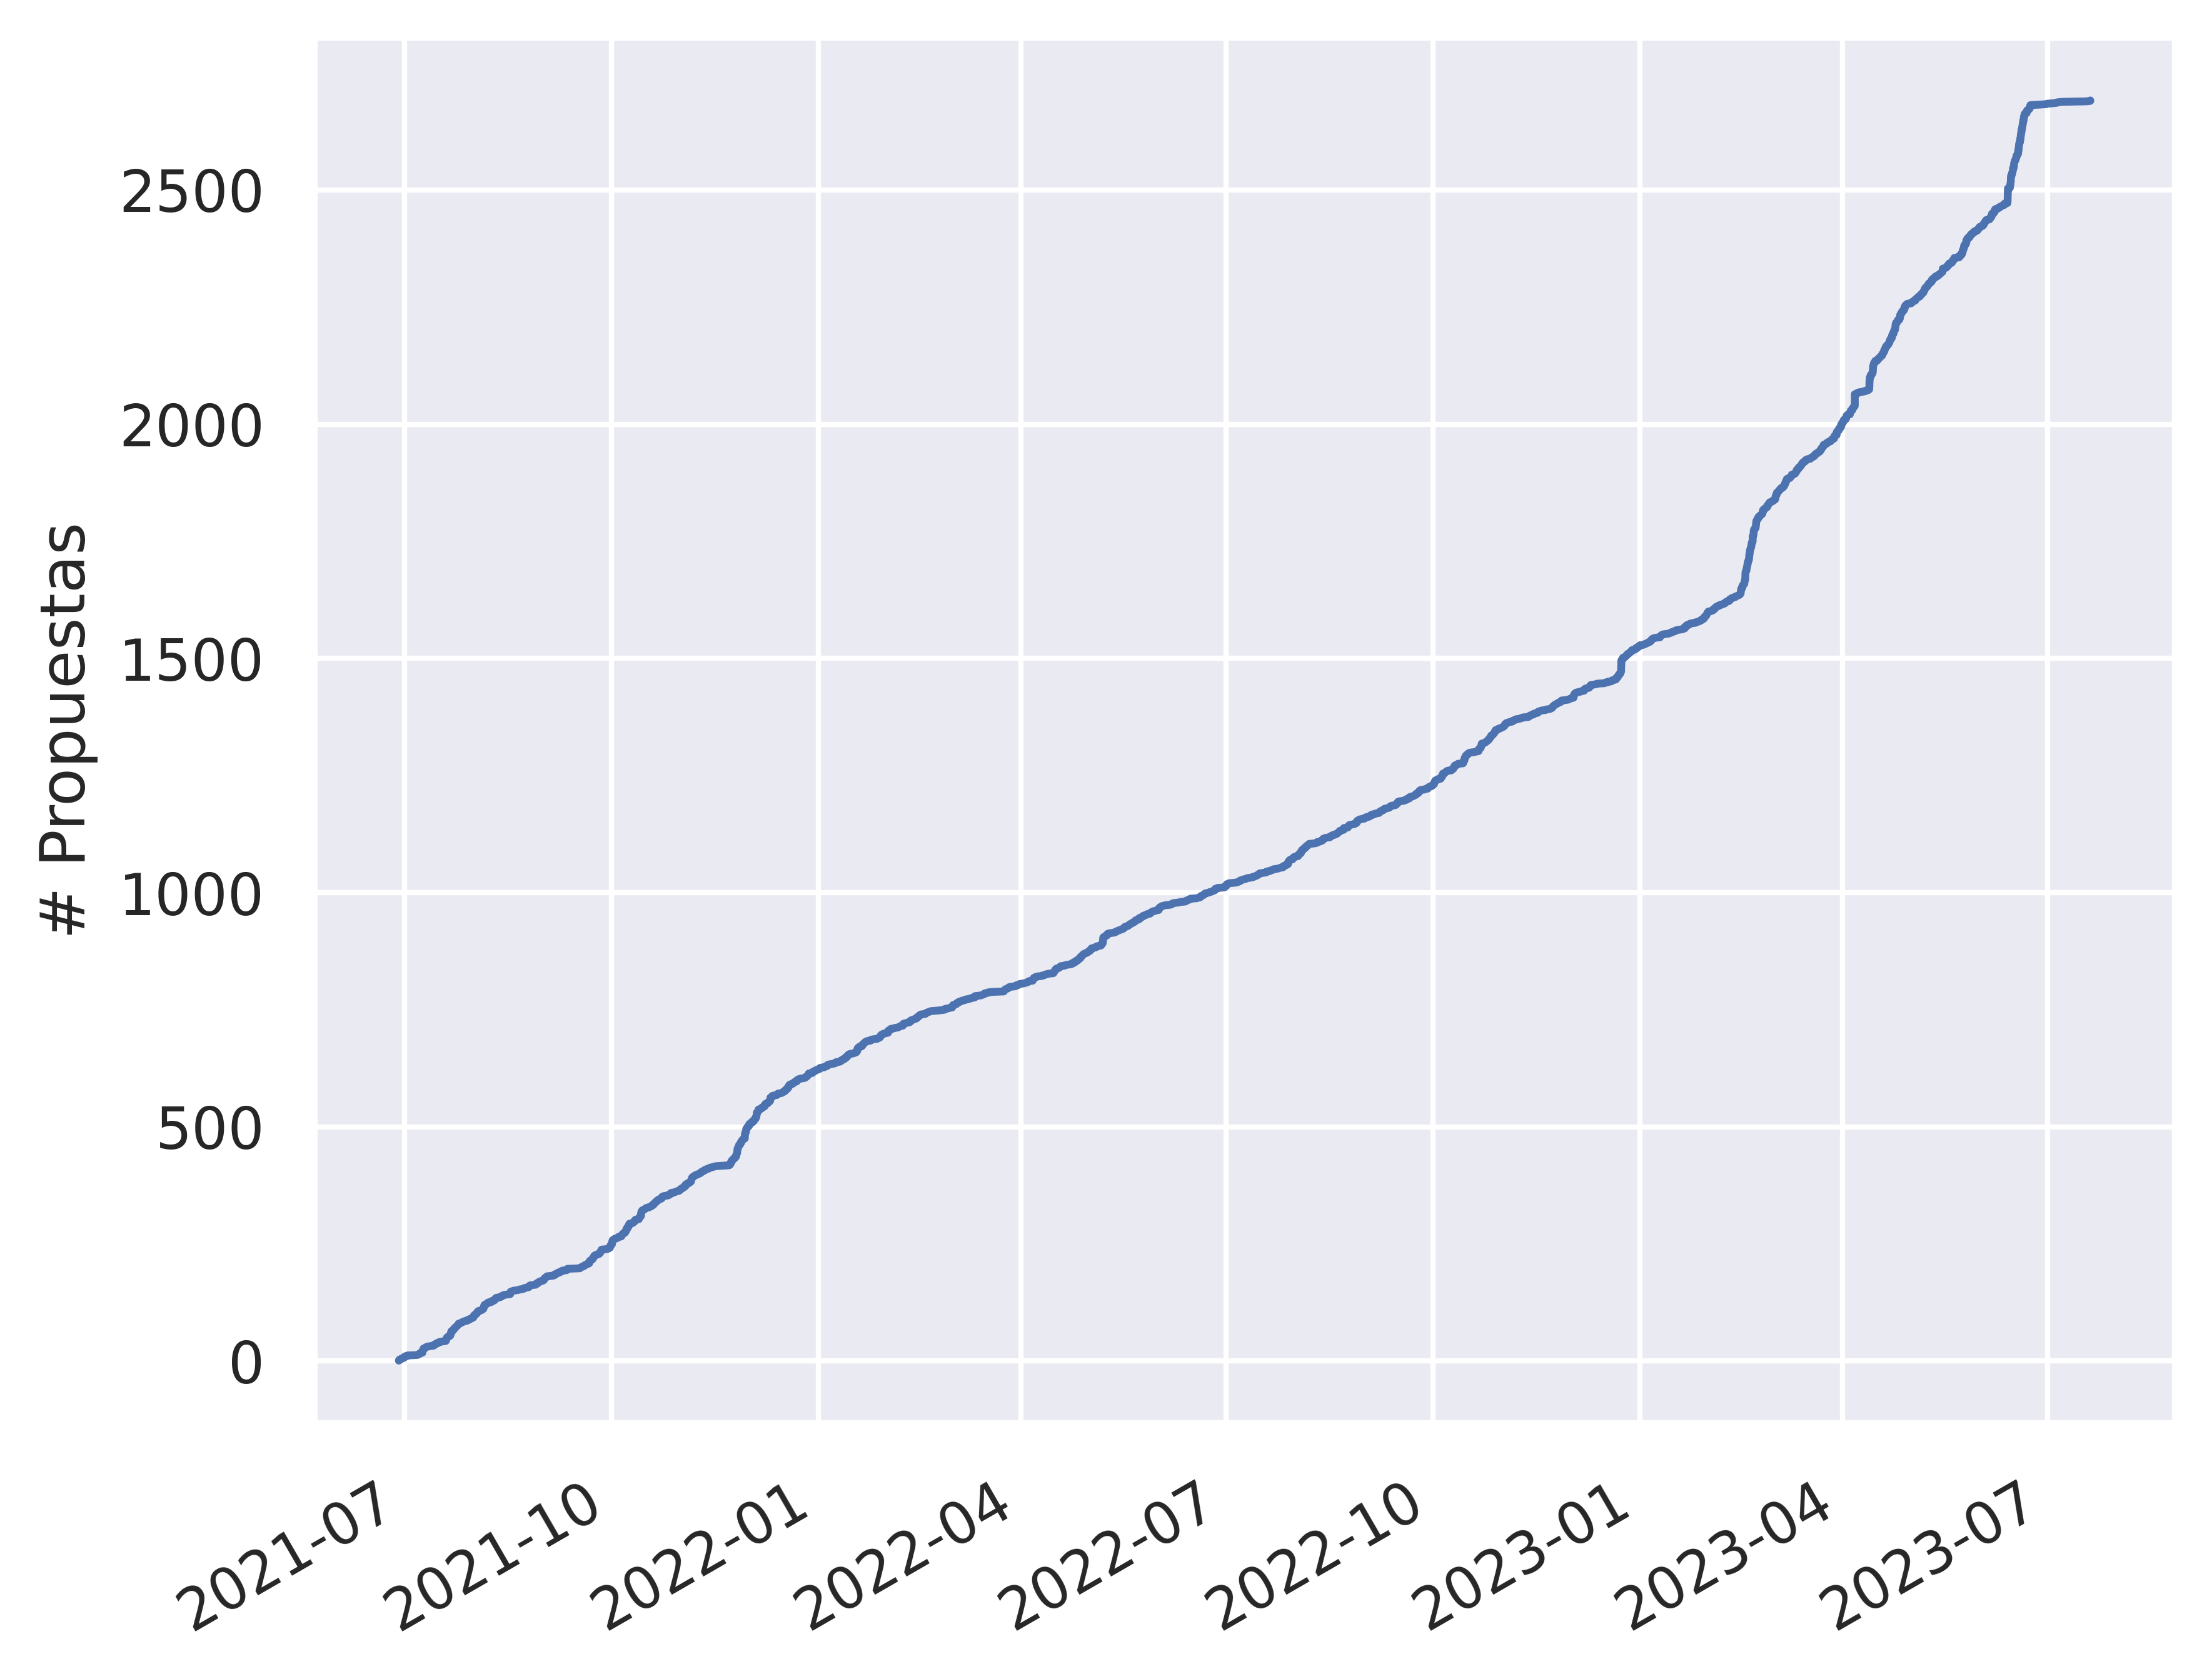

In [13]:
_toplot = dfv.groupby('proposal')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Propuestas')

nbutils.download_matplotlib(ax.figure, f'04c_cumcnt_users_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

<Figure size 3840x2880 with 0 Axes>

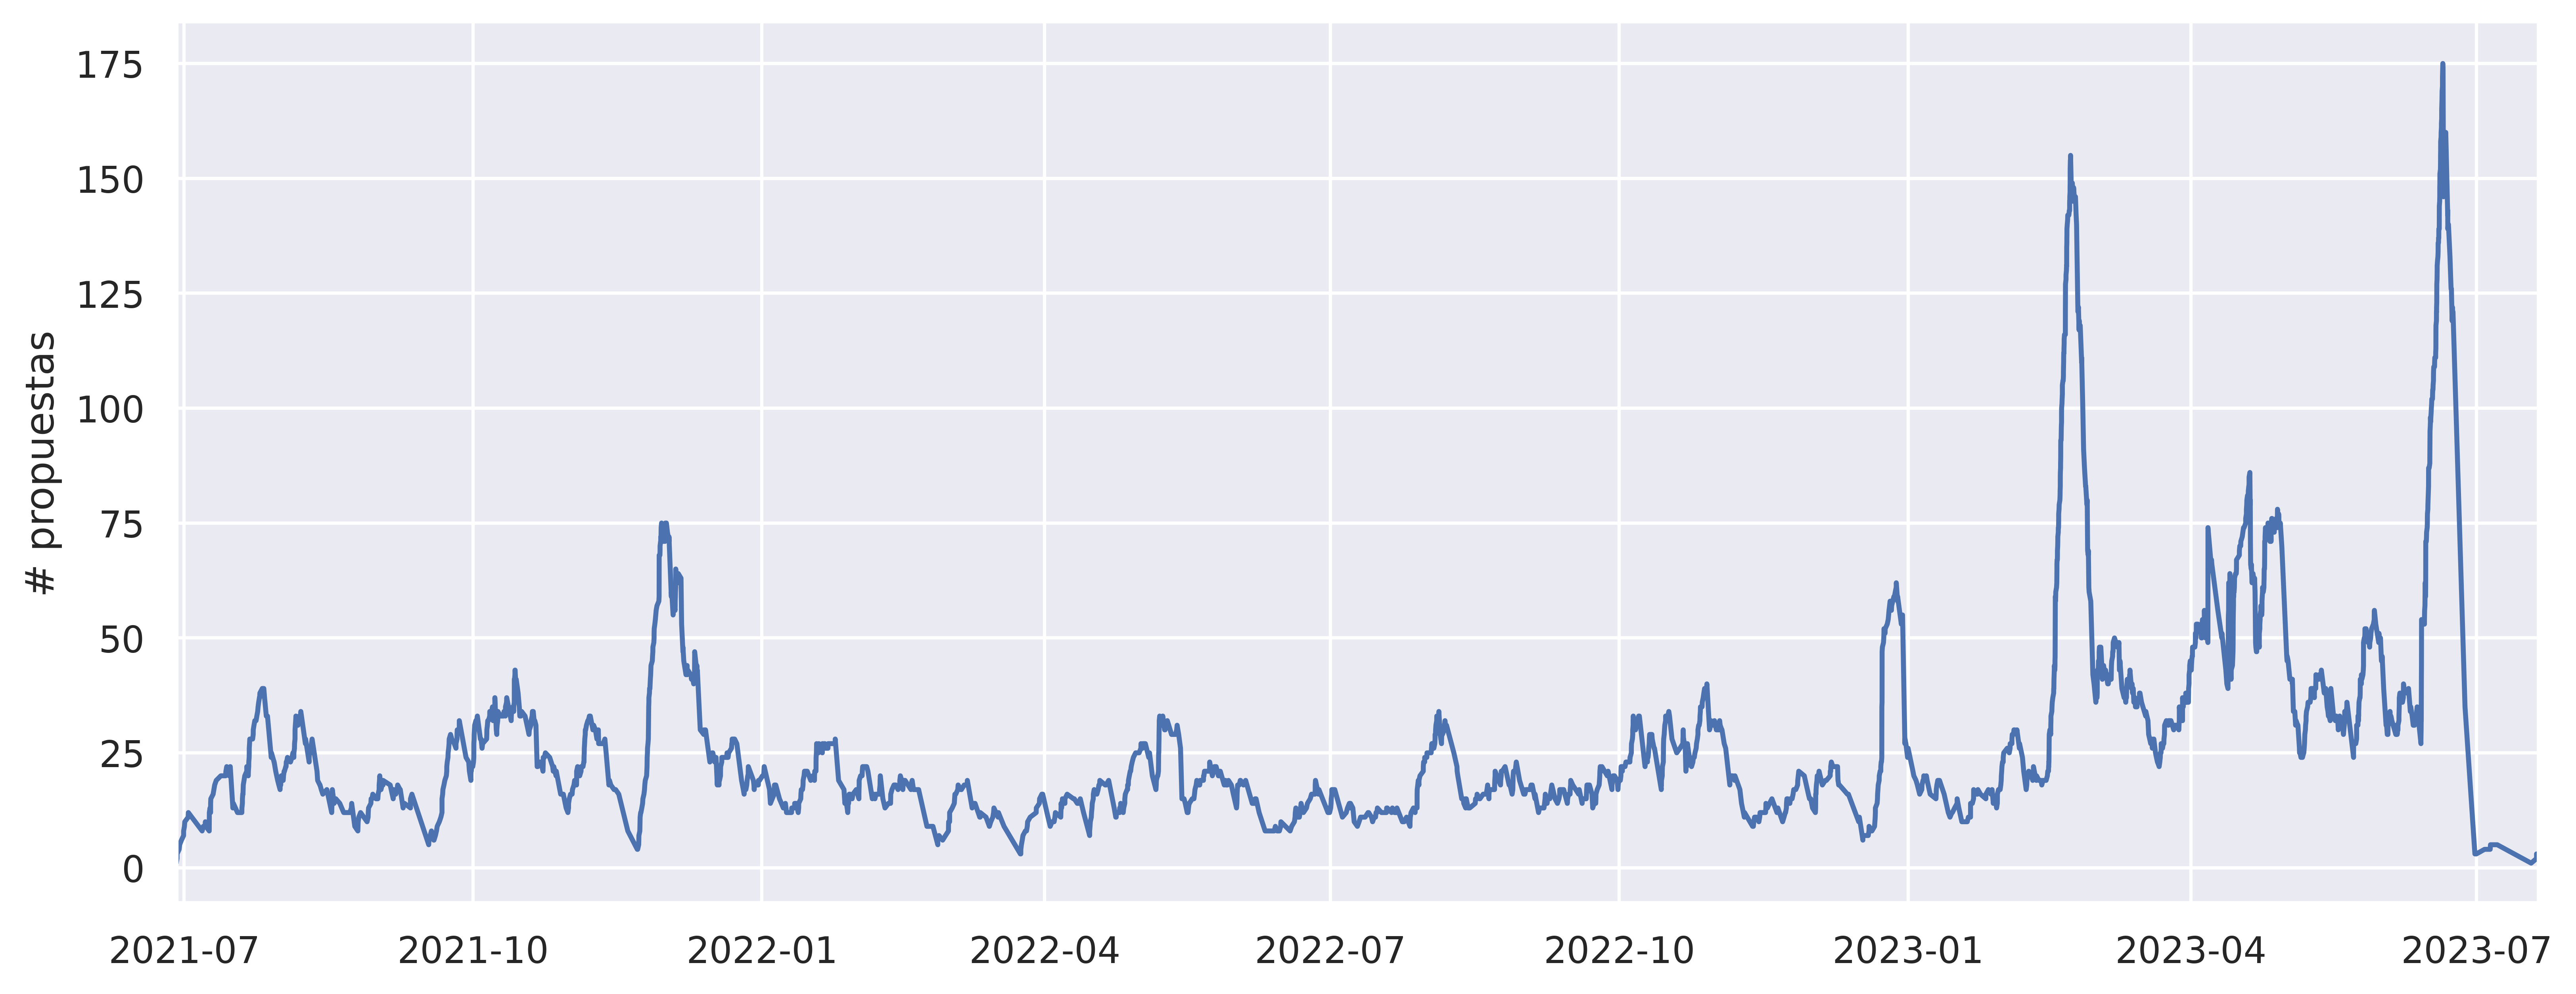

In [14]:
WINDOW_SIZE = '7D'

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=(fs[0]*2, fs[1]))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)

sns.despine()
nbutils.download_matplotlib(ax.figure, f'04c_rolling_proposals_{WINDOW_SIZE}_{ORG_NAME}.pdf')

## Dia de la semana en que se votan las propuestas

> incluso, se podría hacer un heatmap X cuando se lanzan Y cuando se votan y Z (color) la frecuencia
> -- Javi

Vamos, que en esta celda vamos a intentar hacer un HEATMAP donde:
- X: dia de la semana de creación de la propuesta
- Y: dia de la semana de votación
- Z: número de votos

In [15]:
_toplot.to_numpy()

array([[Timestamp('2021-06-28 12:14:46'), 1.0],
       [Timestamp('2021-06-28 18:22:02'), 2.0],
       [Timestamp('2021-06-28 18:26:45'), 3.0],
       ...,
       [Timestamp('2023-07-18 09:01:29'), 1.0],
       [Timestamp('2023-07-20 02:16:20'), 2.0],
       [Timestamp('2023-07-20 02:16:56'), 3.0]], dtype=object)

Text(277.49999999999994, 0.5, 'Día votación')

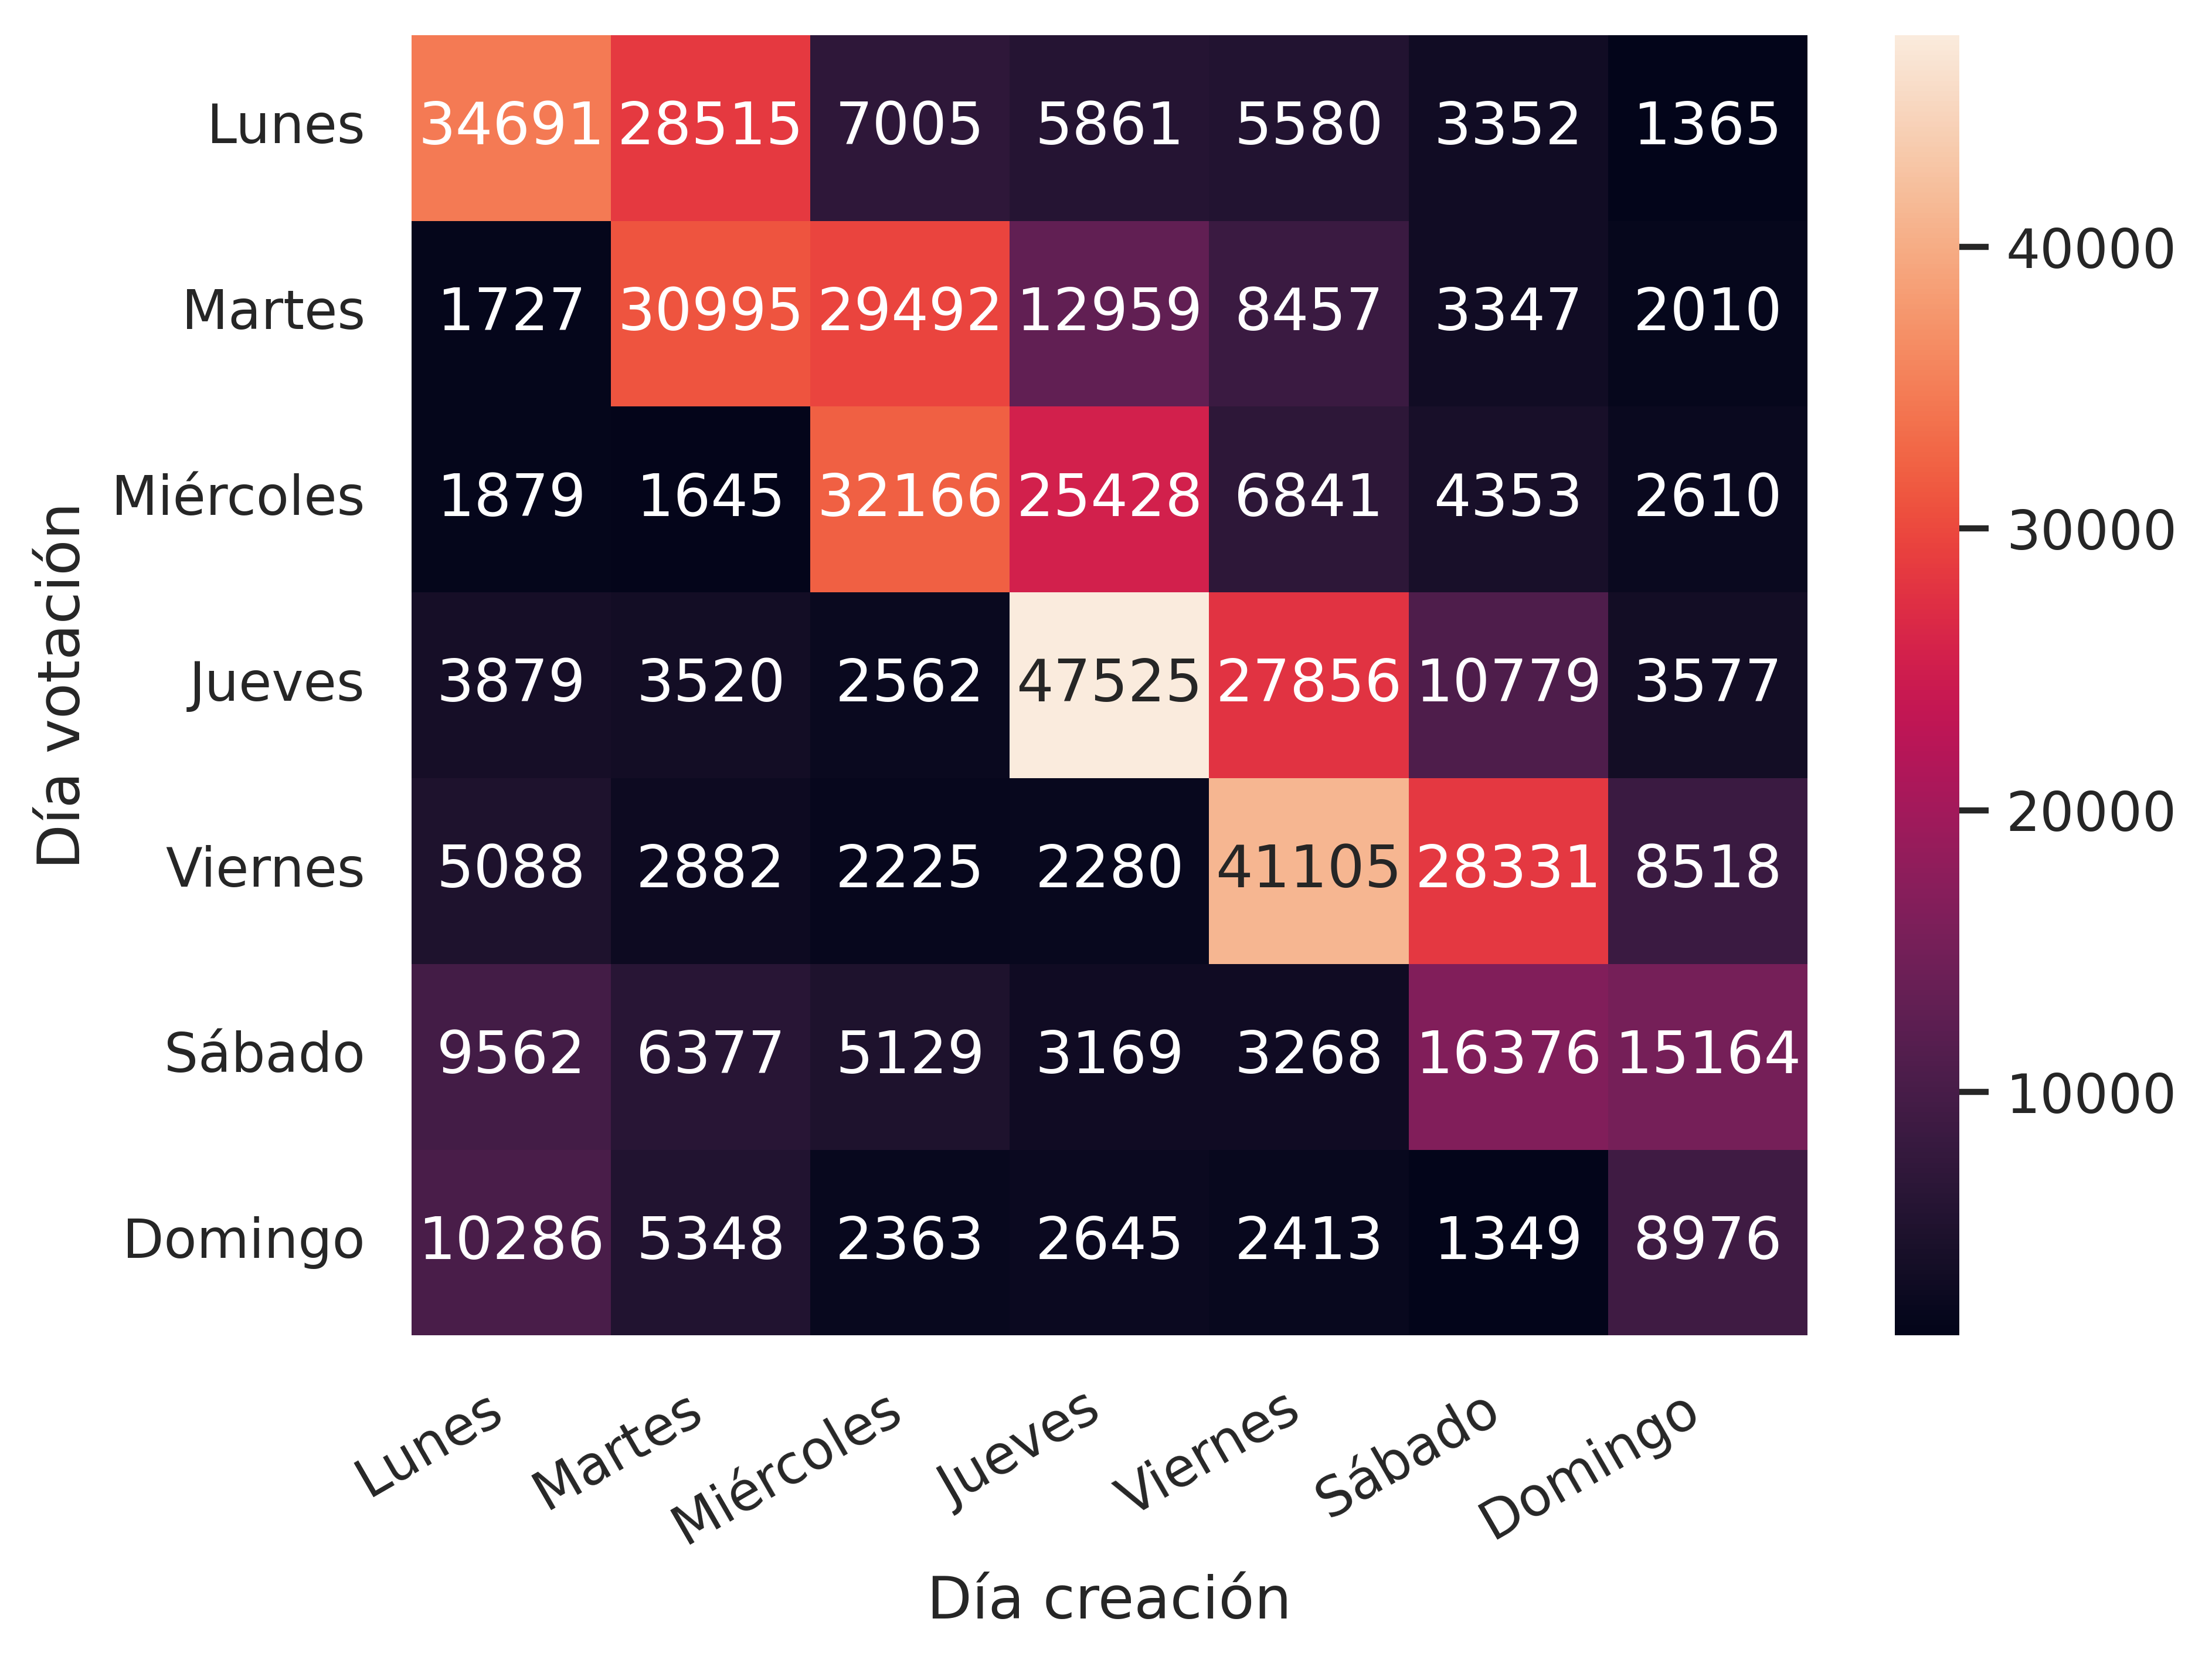

In [16]:
# In pandas, 0 = Monday
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html

spanish_dow = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes', 
    5: 'Sábado',
    6: 'Domingo',
}

_dfvp = dfv.merge(dfp['date'].rename('proposal_date'), left_on='proposal', right_index=True)
_dfvp['date_dow'] = _dfvp['date'].dt.day_of_week
_dfvp['proposal_date_dow'] = _dfvp['proposal_date'].dt.dayofweek
# sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
_toplot = pd.crosstab(_dfvp['proposal_date_dow'], _dfvp['date_dow']).rename(index=spanish_dow, columns=spanish_dow)

sns.heatmap(_toplot, annot=True, fmt='g')
plt.xticks(rotation=30, ha='right')

plt.xlabel('Día creación')
plt.ylabel('Día votación')

Cannot show ipywidgets in text

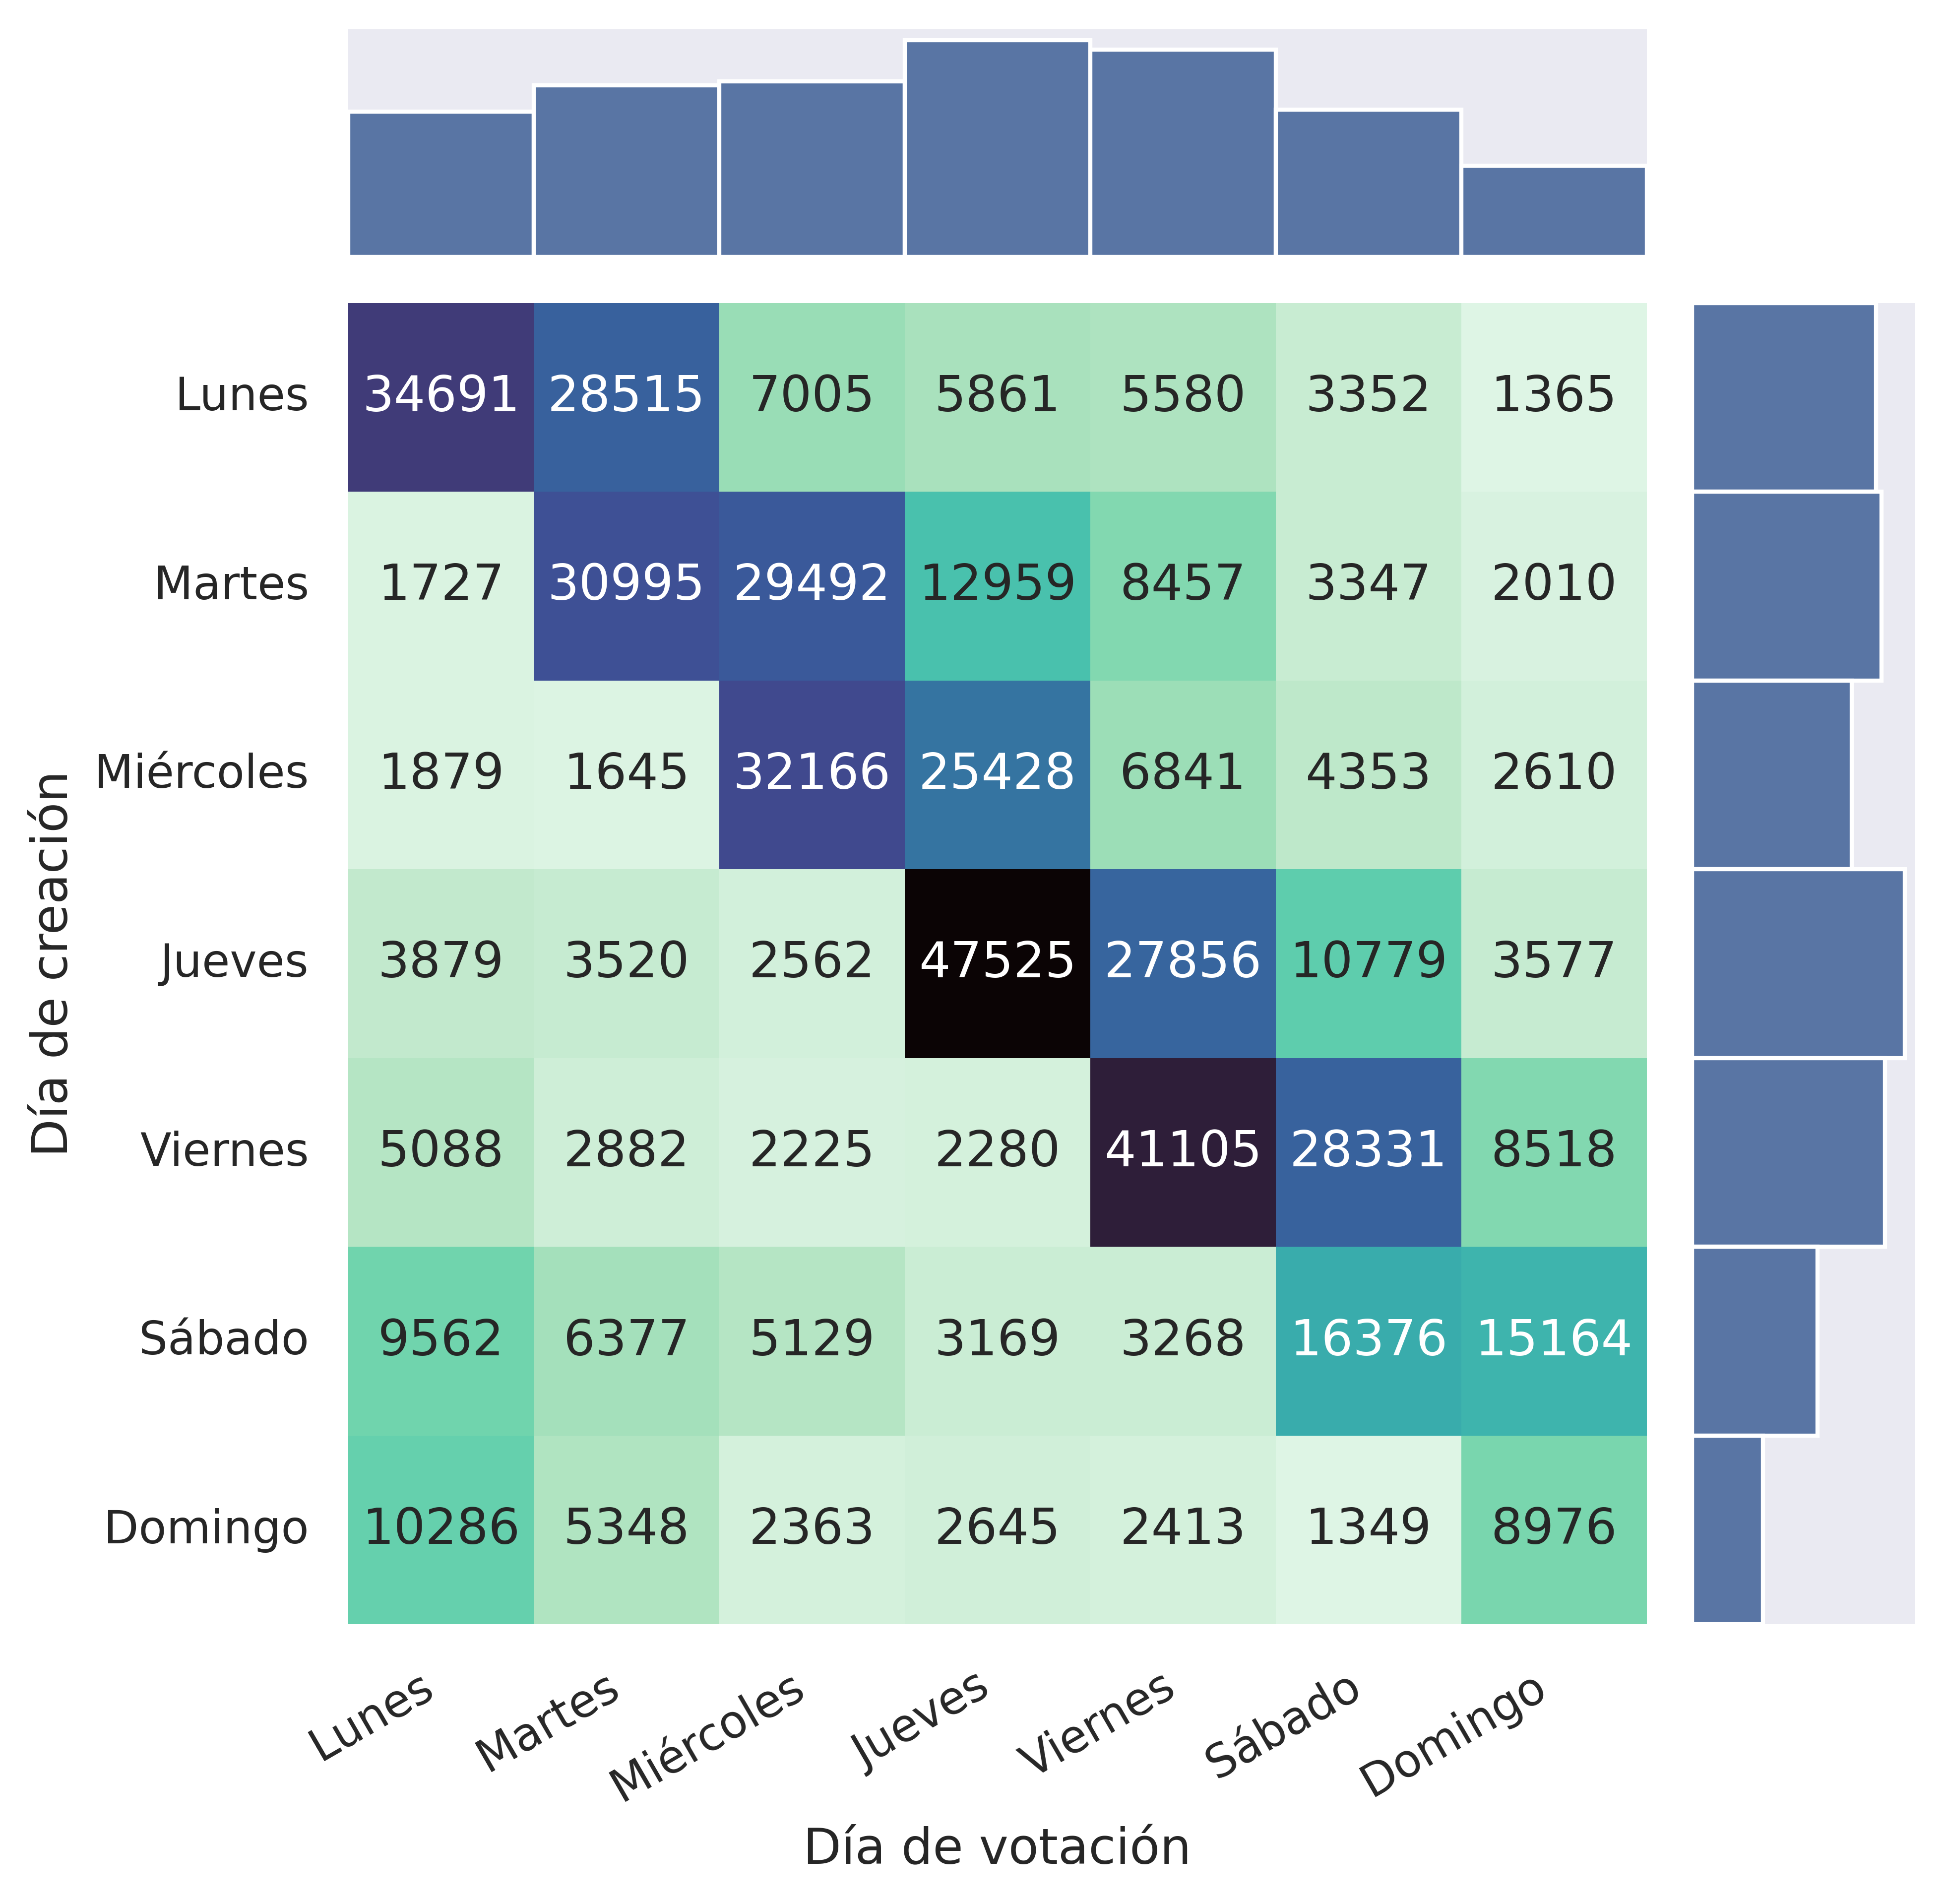

In [17]:
# _toplot = pd.crosstab(...)

grid = sns.JointGrid()

sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt='g', cmap='mako_r')
sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=1)
sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=1)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

grid.ax_joint.set_xticklabels(grid.ax_joint.get_xticklabels(), rotation=30, ha='right')
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Día de votación')
grid.ax_joint.set_ylabel('Día de creación')

nbutils.download_matplotlib(grid, f'04c_heatmap_proposals_{ORG_NAME}.pdf')

<Axes: xlabel='proposal_date_dow', ylabel='count'>

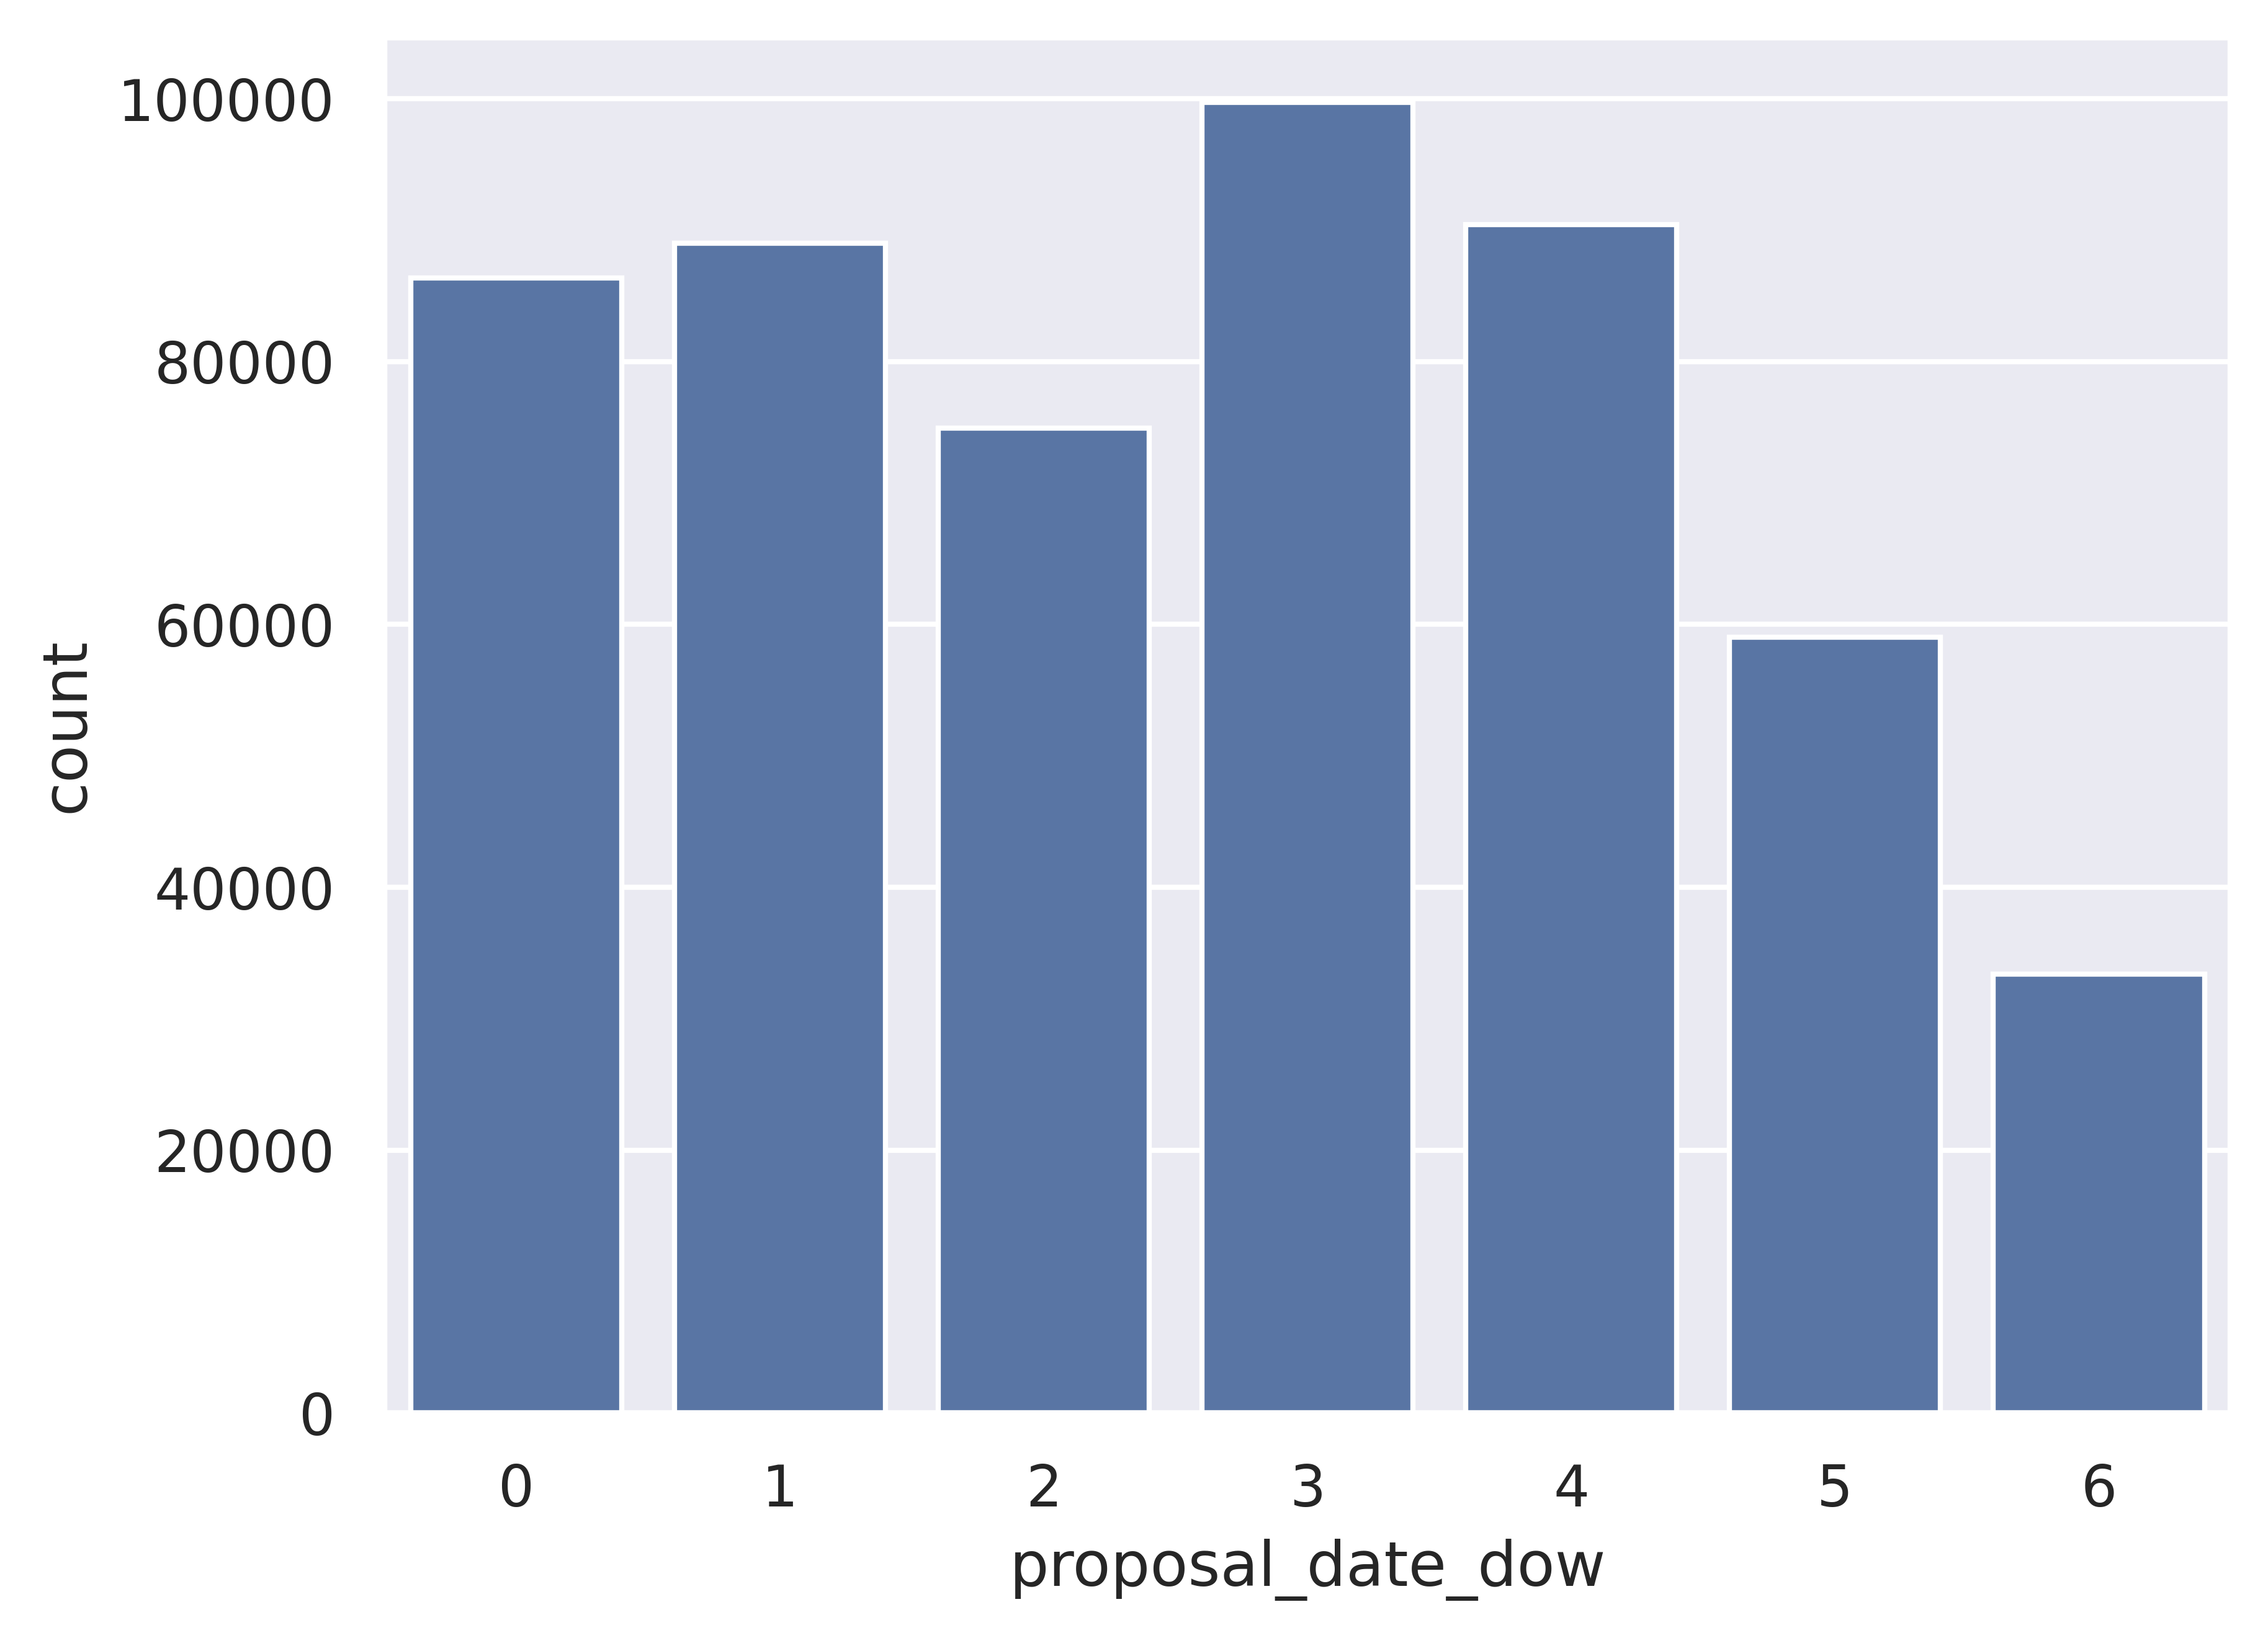

In [18]:
sns.countplot(_dfvp, x='proposal_date_dow')

<Axes: xlabel='count', ylabel='date_dow'>

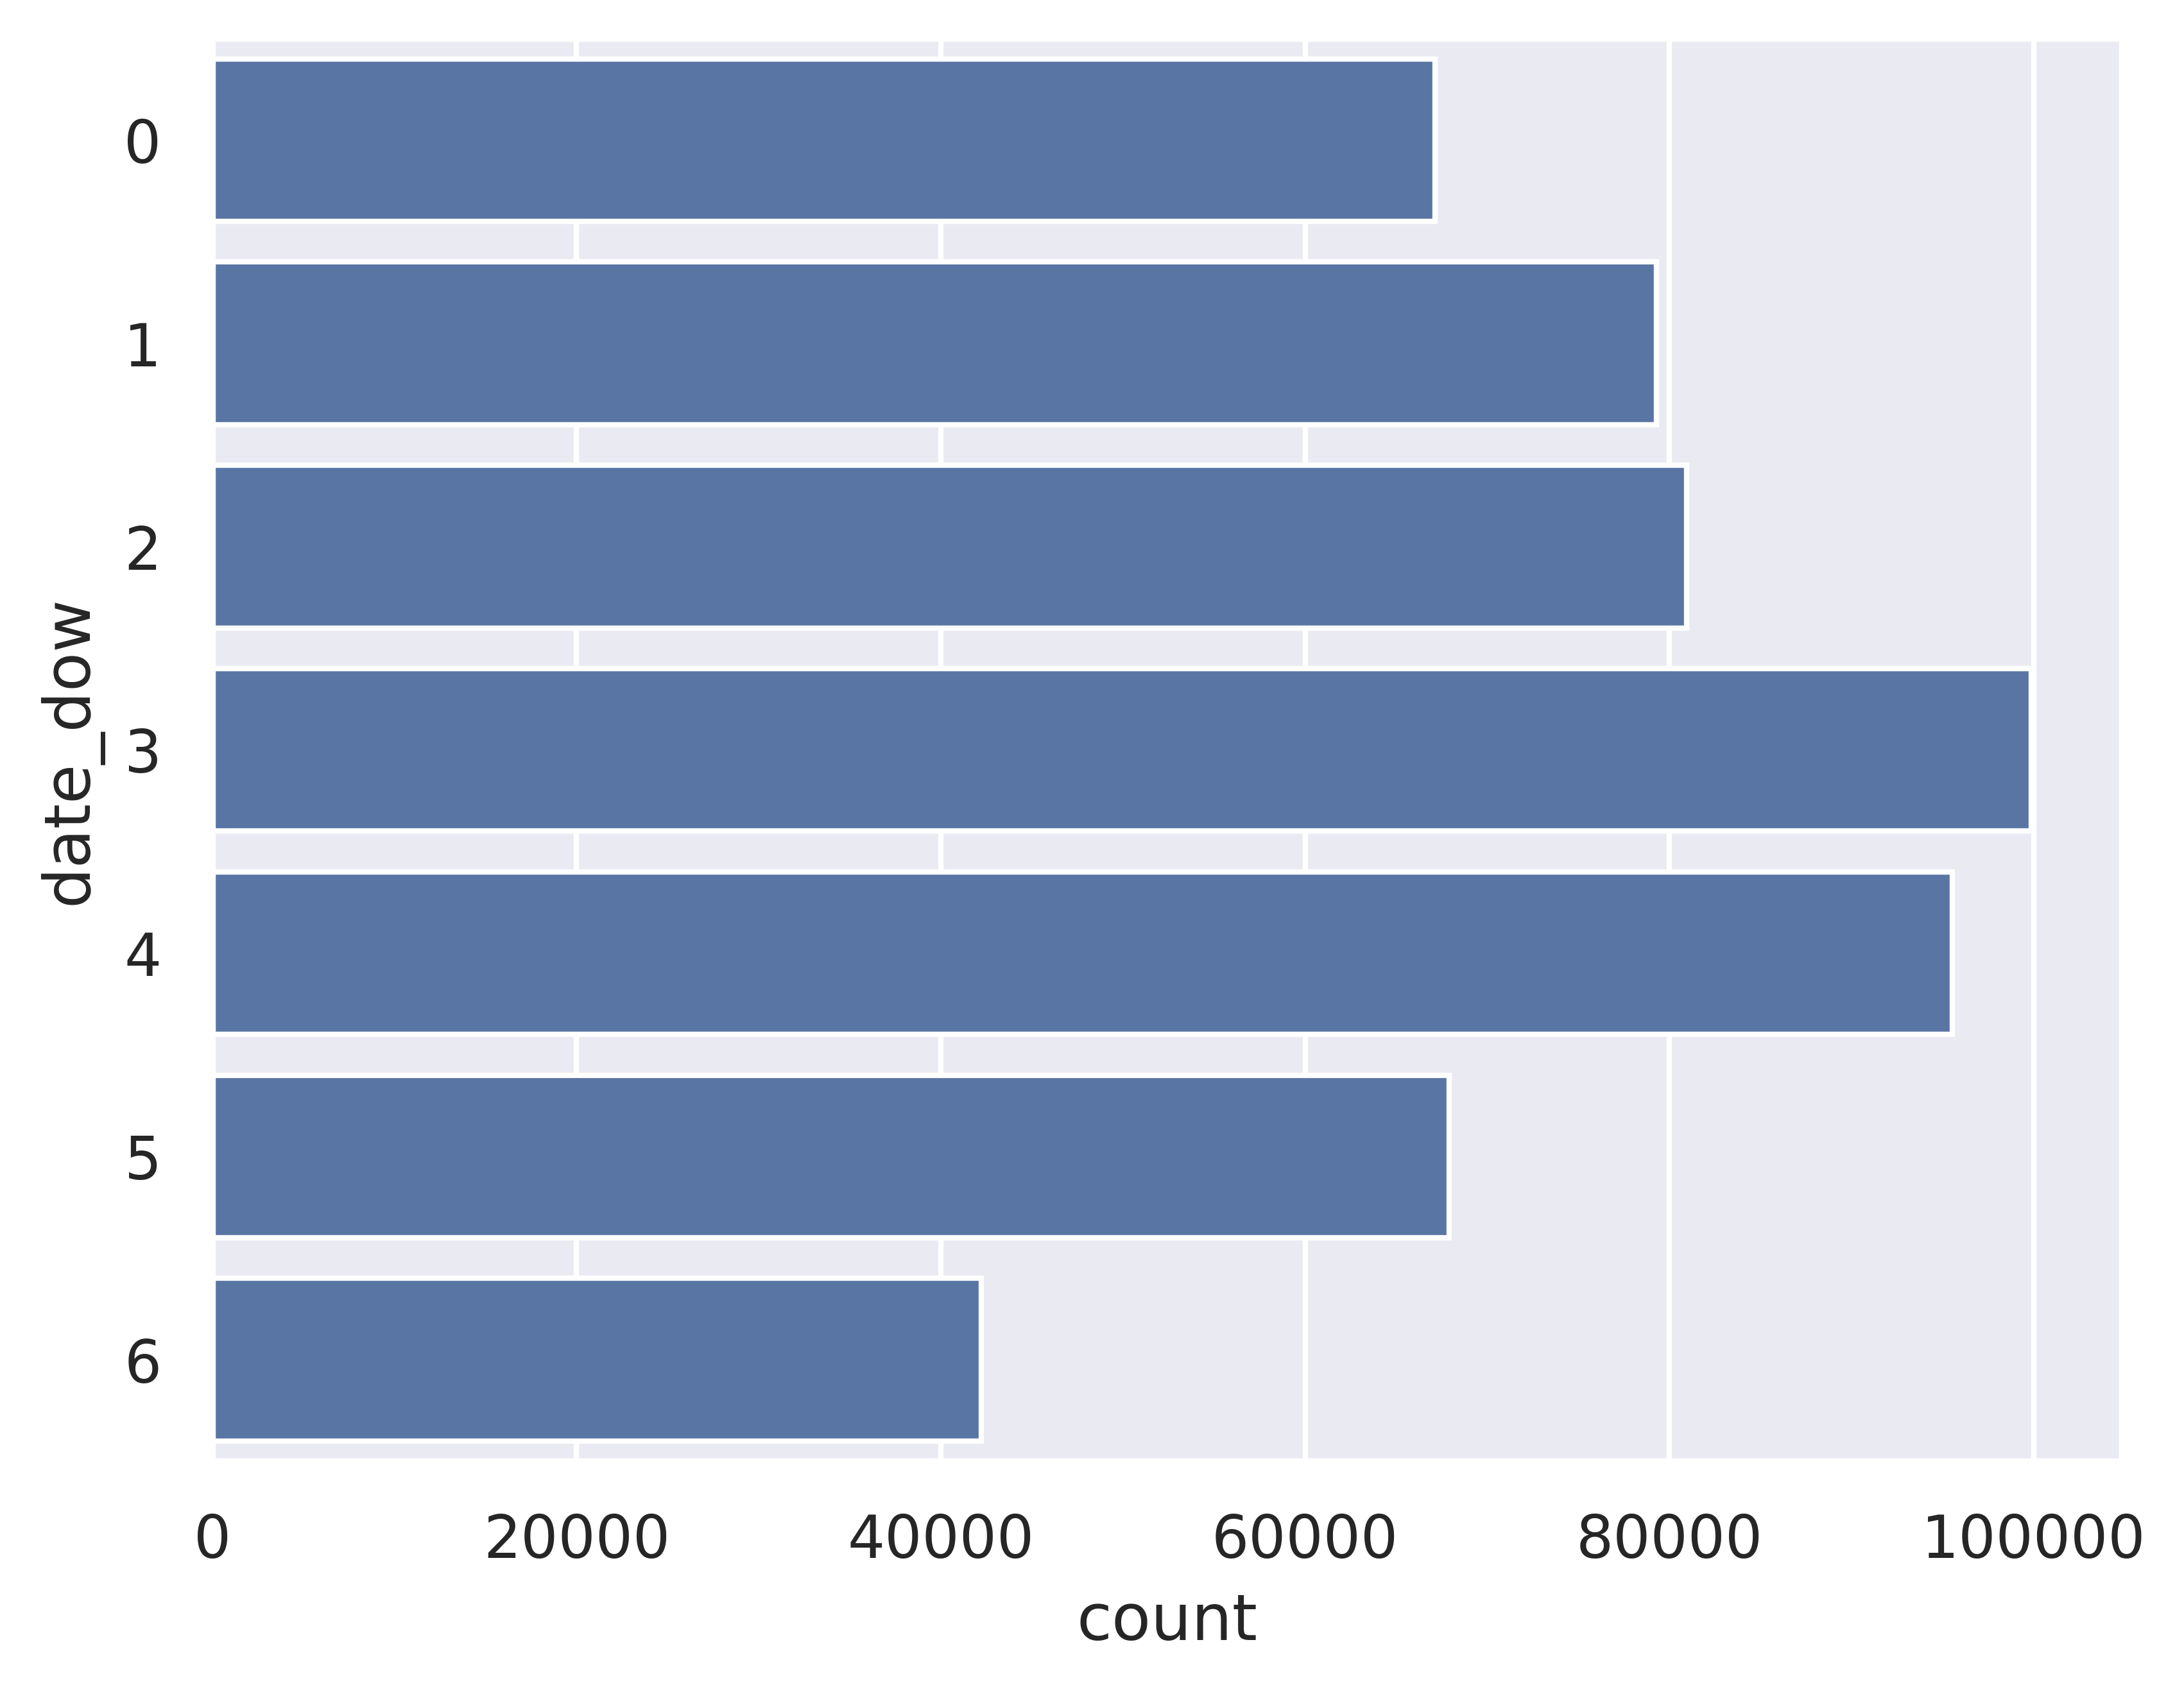

In [19]:
sns.countplot(_dfvp, y='date_dow')

## Suelen votarse las propuestas al principio o al final

In [20]:
def proposal_histogram(proposal):
    p = dfp.loc[proposal]
    _aux = dfv[dfv["proposal"] == proposal][['platform', 'name', 'date']].copy().sort_values('date')
    first_vote = p['start']
    last_vote = p['end']
    print(p['start'], p['end'], p['end'] - p['start'])
    _aux['date_rel'] = (_aux['date'] - p['start']) / (p['end'] - p['start'])
    # sns.ecdfplot(_aux['date_rel'])
    ax = sns.histplot(_aux['date_rel'])
    ax.set_title(f"Histograma de tiempo de los votos en la propuesta {proposal}")
    return ax

# proposal_histogram(proposal = "b86aa059-3d31-5d41-a472-70962816f779")

## Ahora para TODOS los votos

Cuidado que este grafo puede estar sesgado por una sola propuesta

In [21]:
dfp

platform         name  \
id                                                            
b771e498-0ba7-5c86-a10a-ab643c7c7d96  snapshot  PancakeSwap   
26aefaf8-490c-5daa-ac52-b96341034397  snapshot  PancakeSwap   
8d34e5fd-941e-5bce-b473-d7410de6dc2c  snapshot  PancakeSwap   
36138dbb-f772-5651-9bf1-228029e5a920  snapshot  PancakeSwap   
65e23ff5-4781-54e4-9b93-6ee9430304cf  snapshot  PancakeSwap   
...                                        ...          ...   
733ff8b9-ba54-59c8-b020-53233fff9e0e  snapshot  PancakeSwap   
43d09929-99cb-5890-9e4d-c7d76a9c64f7  snapshot  PancakeSwap   
c3b110dc-0131-5c42-98d5-0d7cdf40acca  snapshot  PancakeSwap   
7ff063f6-838c-591f-a6ff-ee8ed894b25a  snapshot  PancakeSwap   
c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe  snapshot  PancakeSwap   

                                     platform_deployment  \
id                                                         
b771e498-0ba7-5c86-a10a-ab643c7c7d96        cakevote.eth   
26aefaf8-490c-5daa-ac52-b96341034397        cakevote.eth   
8d34e5fd-941e-5bce-b473-d7410de6dc2c        cakevote.eth   
36138dbb-f772-5651-9bf1-228029e5a920        cakevote.eth   
65e23ff5-4781-54e4-9b93-6ee9430304cf        cakevote.eth   
...                                                  ...   
733ff8b9-ba54-59c8-b020-53233fff9e0e        cakevote.eth   
43d09929-99cb-5890-9e4d-c7d76a9c64f7        cakevote.eth   
c3b110dc-0131-5c42-98d5-0d7cdf40acca        cakevote.eth   
7ff063f6-838c-591f-a6ff-ee8ed894b25a        cakevote.eth   
c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe        cakevote.eth   

                                                                deployment  \
id                                                                           
b771e498-0ba7-5c86-a10a-ab643c7c7d96  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   
26aefaf8-490c-5daa-ac52-b96341034397  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   
8d34e5fd-941e-5bce-b473-d7410de6dc2c  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   
36138dbb-f772-5651-9bf1-228029e5a920  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   
65e23ff5-4781-54e4-9b93-6ee9430304cf  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   
...                                                                    ...   
733ff8b9-ba54-59c8-b020-53233fff9e0e  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   
43d09929-99cb-5890-9e4d-c7d76a9c64f7  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   
c3b110dc-0131-5c42-98d5-0d7cdf40acca  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   
7ff063f6-838c-591f-a6ff-ee8ed894b25a  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   
c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe  e2ec62ae-9b29-5f3a-a541-58678bb64a1b   

                                                                      platform_proposal  \
id                                                                                        
b771e498-0ba7-5c86-a10a-ab643c7c7d96  bafkreihyxxv6sdfot4blgez47fizcayla5gnyulw7mfq4...   
26aefaf8-490c-5daa-ac52-b96341034397  bafkreigaj5js2b473drd2k5xtvvo4huuxa7u4gmhqja3x...   
8d34e5fd-941e-5bce-b473-d7410de6dc2c  bafkreig52qzolu4q2k6o3fqo7znh755fpdw3wb2yvgng5...   
36138dbb-f772-5651-9bf1-228029e5a920  bafkreifkpzwtvuz3ftttvanunj7sbjga5twfz5hnpdrlp...   
65e23ff5-4781-54e4-9b93-6ee9430304cf  bafkreifdzj3nxz6ruexujawcao4symjfavoipw7qmtlqb...   
...                                                                                 ...   
733ff8b9-ba54-59c8-b020-53233fff9e0e     Qmc3GaCuxVzArae2jRbuaNcFUDzgKPNbHdEe8DnSqTYNzN   
43d09929-99cb-5890-9e4d-c7d76a9c64f7     Qmbpsio389rXe6xaA38ztPVVHH2kBthhRsL2y13VNdt5va   
c3b110dc-0131-5c42-98d5-0d7cdf40acca     QmWBiott8Z9t4jMiMNv5oP6XZsERcvLhDed8NP4NPDZTtG   
7ff063f6-838c-591f-a6ff-ee8ed894b25a     QmfDqrSAYQY4BieB7Xh2jdc6mGwyfWoP9Lxw5ecdP1L7si   
c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe     QmdT8f7BP2YhaCEFmxURgqN4E4iGAviBUG1Q7rocBwGfG1   

                                                                          author  \
id                                                                                 
b771e498-0ba7-5c86-a10a-ab643c7c7d96  0x842b508681ee336e74600974b4623b

Text(0.5, 1.0, 'Histograma de todos los votos realizados en PancakeSwap')

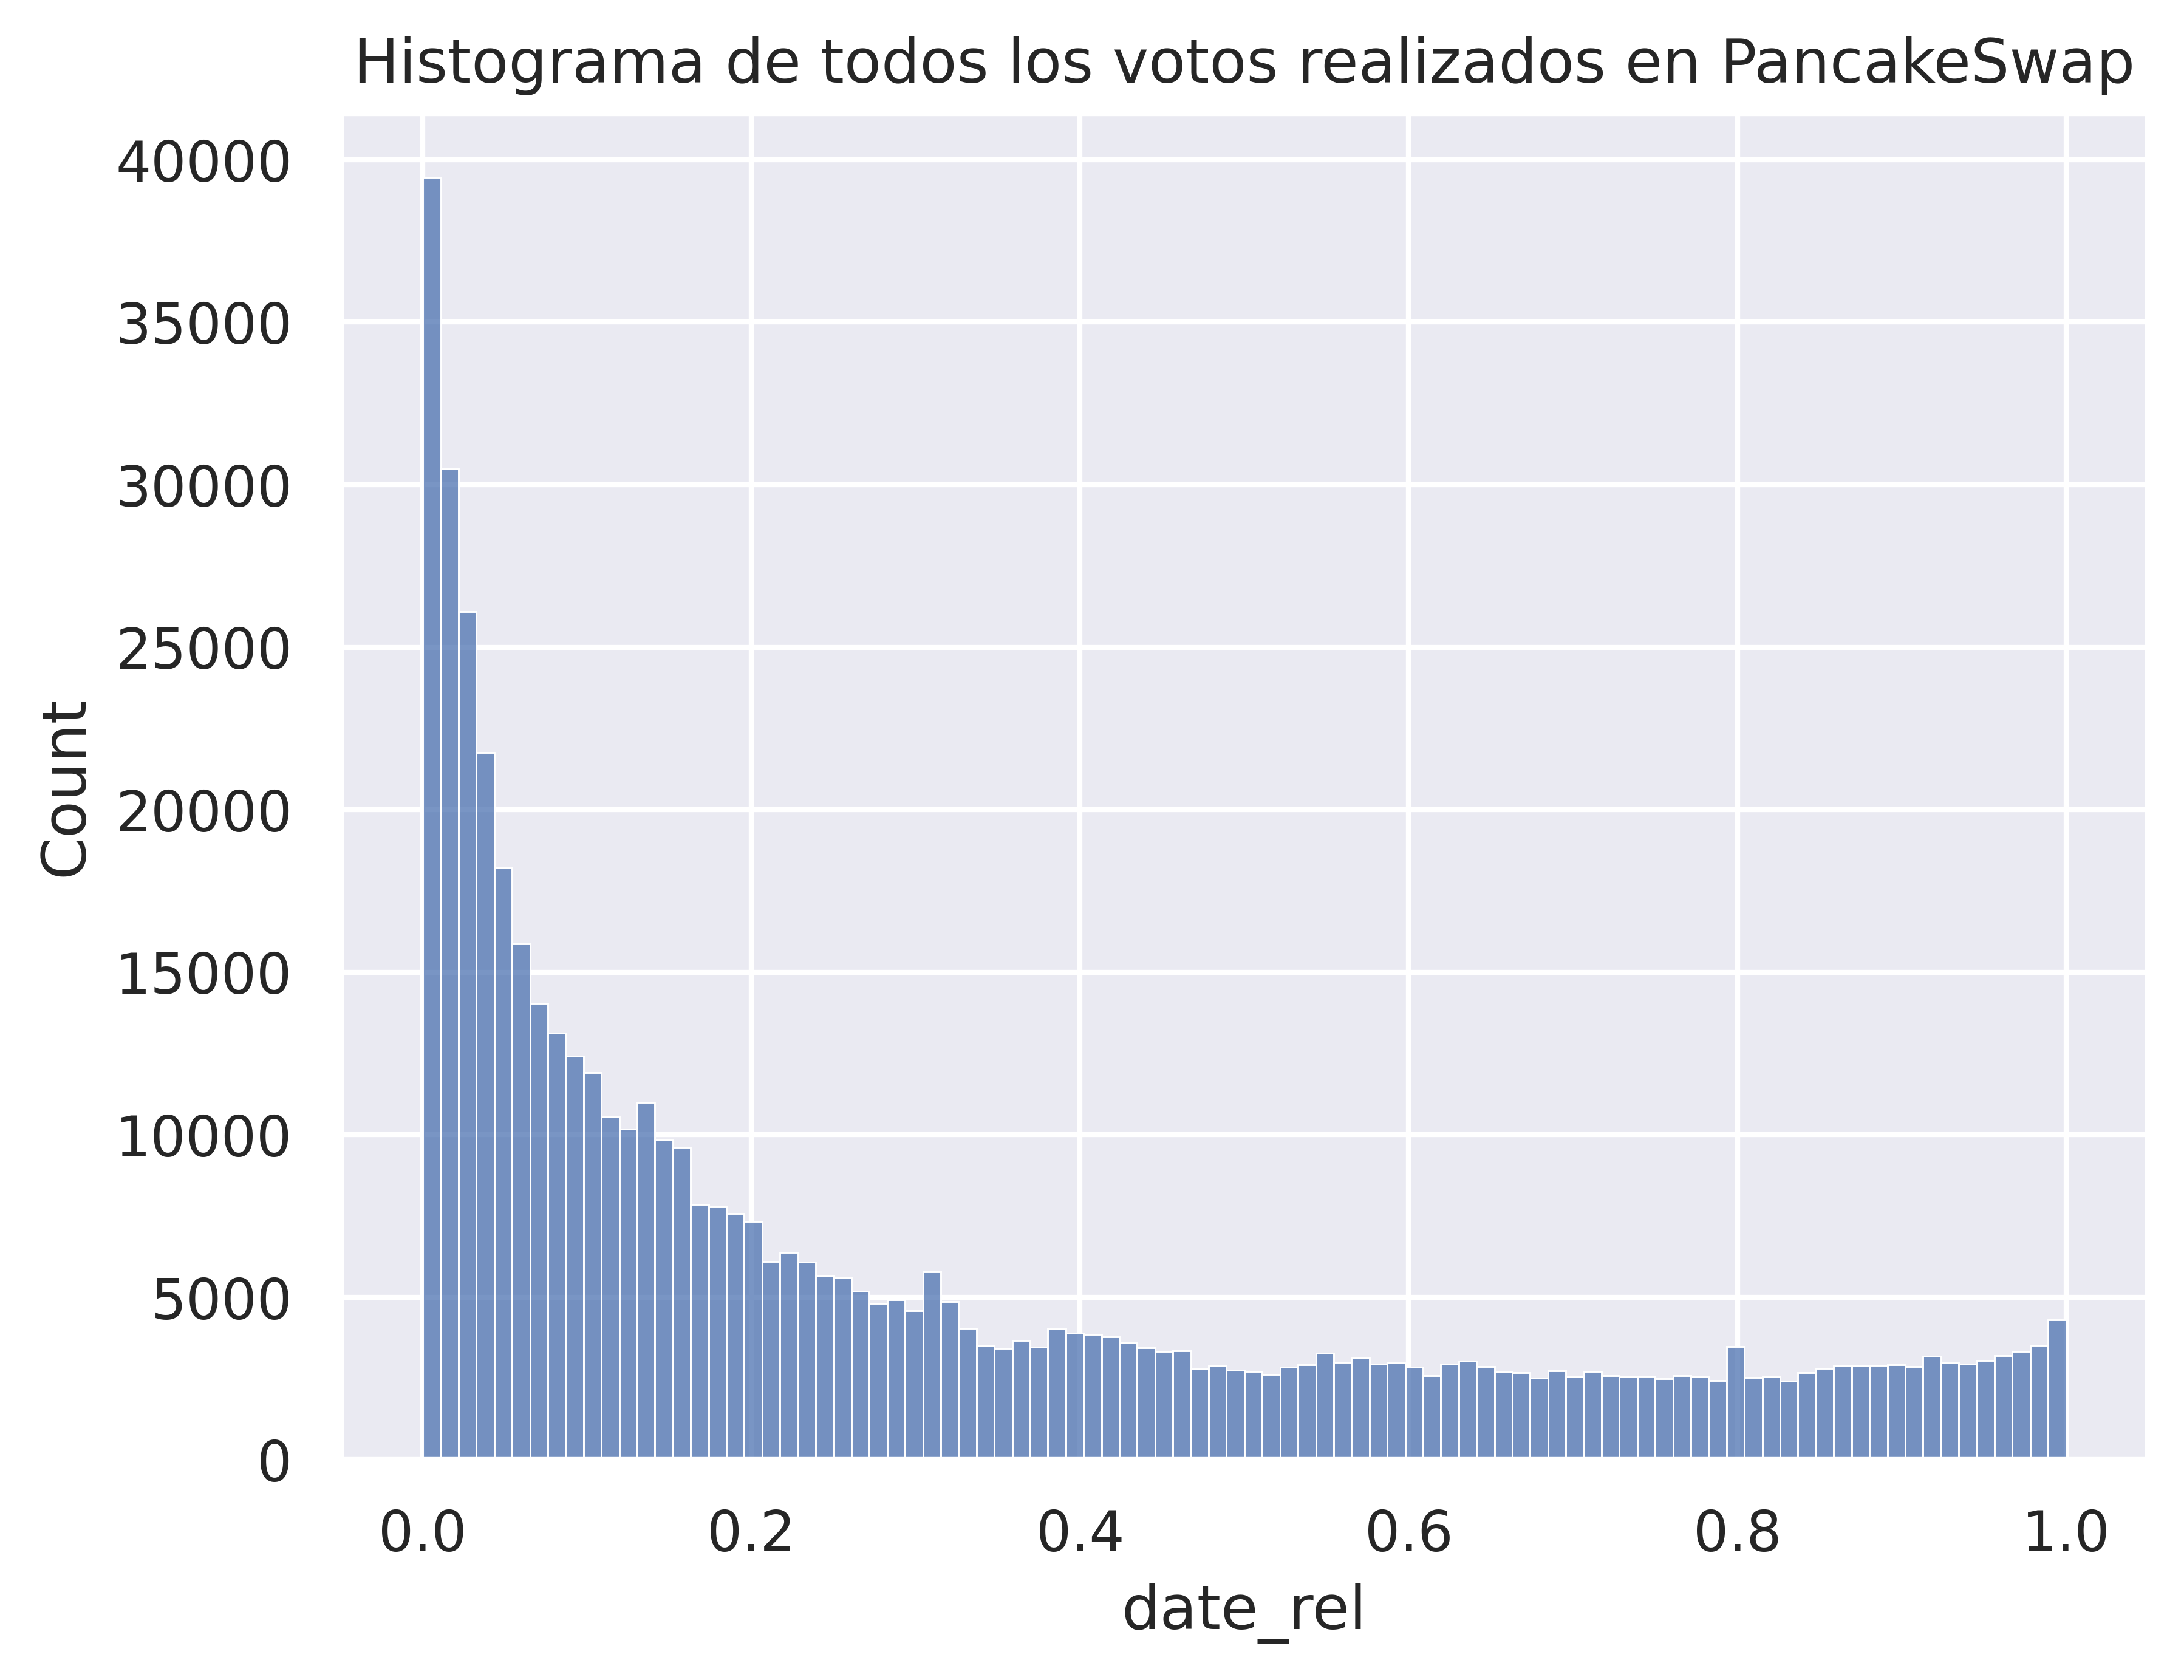

In [22]:
_dfv = dfv[['platform', 'name', 'proposal', 'date']].merge(dfp[['start', 'end']], left_on='proposal', right_index=True).sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
ax = sns.histplot(_dfv, x='date_rel')
ax.set_title(f"Histograma de todos los votos realizados en {ORG_NAME}")

In [23]:
_dfv[['date_rel']].describe(percentiles=[.1,.25,.5,.75,.78,.8])

date_rel
count  532830.000000
mean        0.299111
std         0.296443
min         0.000000
10%         0.015706
25%         0.052724
50%         0.179585
75%         0.494513
78%         0.555242
80%         0.594163
max         0.999998

### Cuando son los votos (histograma distribución en tiempo de TODOS los votos)

Vamos a intentar calcular la frecuencia relativa acumulada

In [24]:
rel = (1 / _dfv.groupby('proposal').size()).rename('freq')
_dfv2 = _dfv.join(rel, on='proposal')
_dfv2['cumfreq'] = _dfv2.groupby('proposal')['freq'].cumsum()
_dfv2

platform         name                              proposal  \
221486  snapshot  PancakeSwap  c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe   
221485  snapshot  PancakeSwap  c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe   
221484  snapshot  PancakeSwap  c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe   
221483  snapshot  PancakeSwap  c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe   
221482  snapshot  PancakeSwap  c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe   
...          ...          ...                                   ...   
37075   snapshot  PancakeSwap  718fe10e-25cf-5c87-b966-99e1ca411fb1   
37074   snapshot  PancakeSwap  718fe10e-25cf-5c87-b966-99e1ca411fb1   
37073   snapshot  PancakeSwap  718fe10e-25cf-5c87-b966-99e1ca411fb1   
37072   snapshot  PancakeSwap  718fe10e-25cf-5c87-b966-99e1ca411fb1   
37071   snapshot  PancakeSwap  718fe10e-25cf-5c87-b966-99e1ca411fb1   

                      date               start                 end  date_rel  \
221486 2021-06-28 12:14:46 2021-06-27 15:00:00 2021-06-29 22:30:00  0.382813   
221485 2021-06-28 12:41:42 2021-06-27 15:00:00 2021-06-29 22:30:00  0.390901   
221484 2021-06-28 12:42:56 2021-06-27 15:00:00 2021-06-29 22:30:00  0.391271   
221483 2021-06-28 12:54:31 2021-06-27 15:00:00 2021-06-29 22:30:00  0.394750   
221482 2021-06-28 16:02:34 2021-06-27 15:00:00 2021-06-29 22:30:00  0.451221   
...                    ...                 ...                 ...       ...   
37075  2023-07-20 03:06:58 2023-07-19 16:00:00 2023-07-20 04:00:00  0.926343   
37074  2023-07-20 03:16:03 2023-07-19 16:00:00 2023-07-20 04:00:00  0.938958   
37073  2023-07-20 03:33:17 2023-07-19 16:00:00 2023-07-20 04:00:00  0.962894   
37072  2023-07-20 03:47:32 2023-07-19 16:00:00 2023-07-20 04:00:00  0.982685   
37071  2023-07-20 03:54:45 2023-07-19 16:00:00 2023-07-20 04:00:00  0.992708   

            freq   cumfreq  
221486  0.026316  0.026316  
221485  0.026316  0.052632  
221484  0.026316  0.078947  
221483  0.026316  0.105263  
221482  0.026316  0.131579  
...          ...       ...  
37075   0.142857  0.428571  
37074   0.142857  0.571429  
37073   0.142857  0.714286  
37072   0.142857  0.857143  
37071   0.142857  1.000000  

[532830 rows x 9 columns]

In [25]:
_dfv2.groupby('proposal').size().sort_values()

proposal
4be2a733-1619-559a-aa24-9b9e59570c64       1
b220e0db-941b-54b7-a726-92b10c76dc37       1
90e6fb35-b2c6-566f-ac30-844aaf5b9bf9       1
f3d97267-e025-5d3c-9c44-183021842412       1
0deb1184-551e-51cc-847c-bae54a75db76       1
                                        ... 
07f03fb5-dfcb-5f10-9141-2257832c0454    3979
28cc9fdb-cf97-5b77-9cf8-0594a2af2976    4618
cbf344c5-e912-5a76-b5b5-5fd4cab522e5    4918
993ffb33-adc7-5c95-aa0e-39e1dff59ddb    5471
04898f82-ab38-5026-8c20-487def4f89b7    8888
Length: 2691, dtype: int64


### KDE plot de las más votadas

Text(0.5, 1.0, 'kde plot de las 15 propuestas más grandes en PancakeSwap')

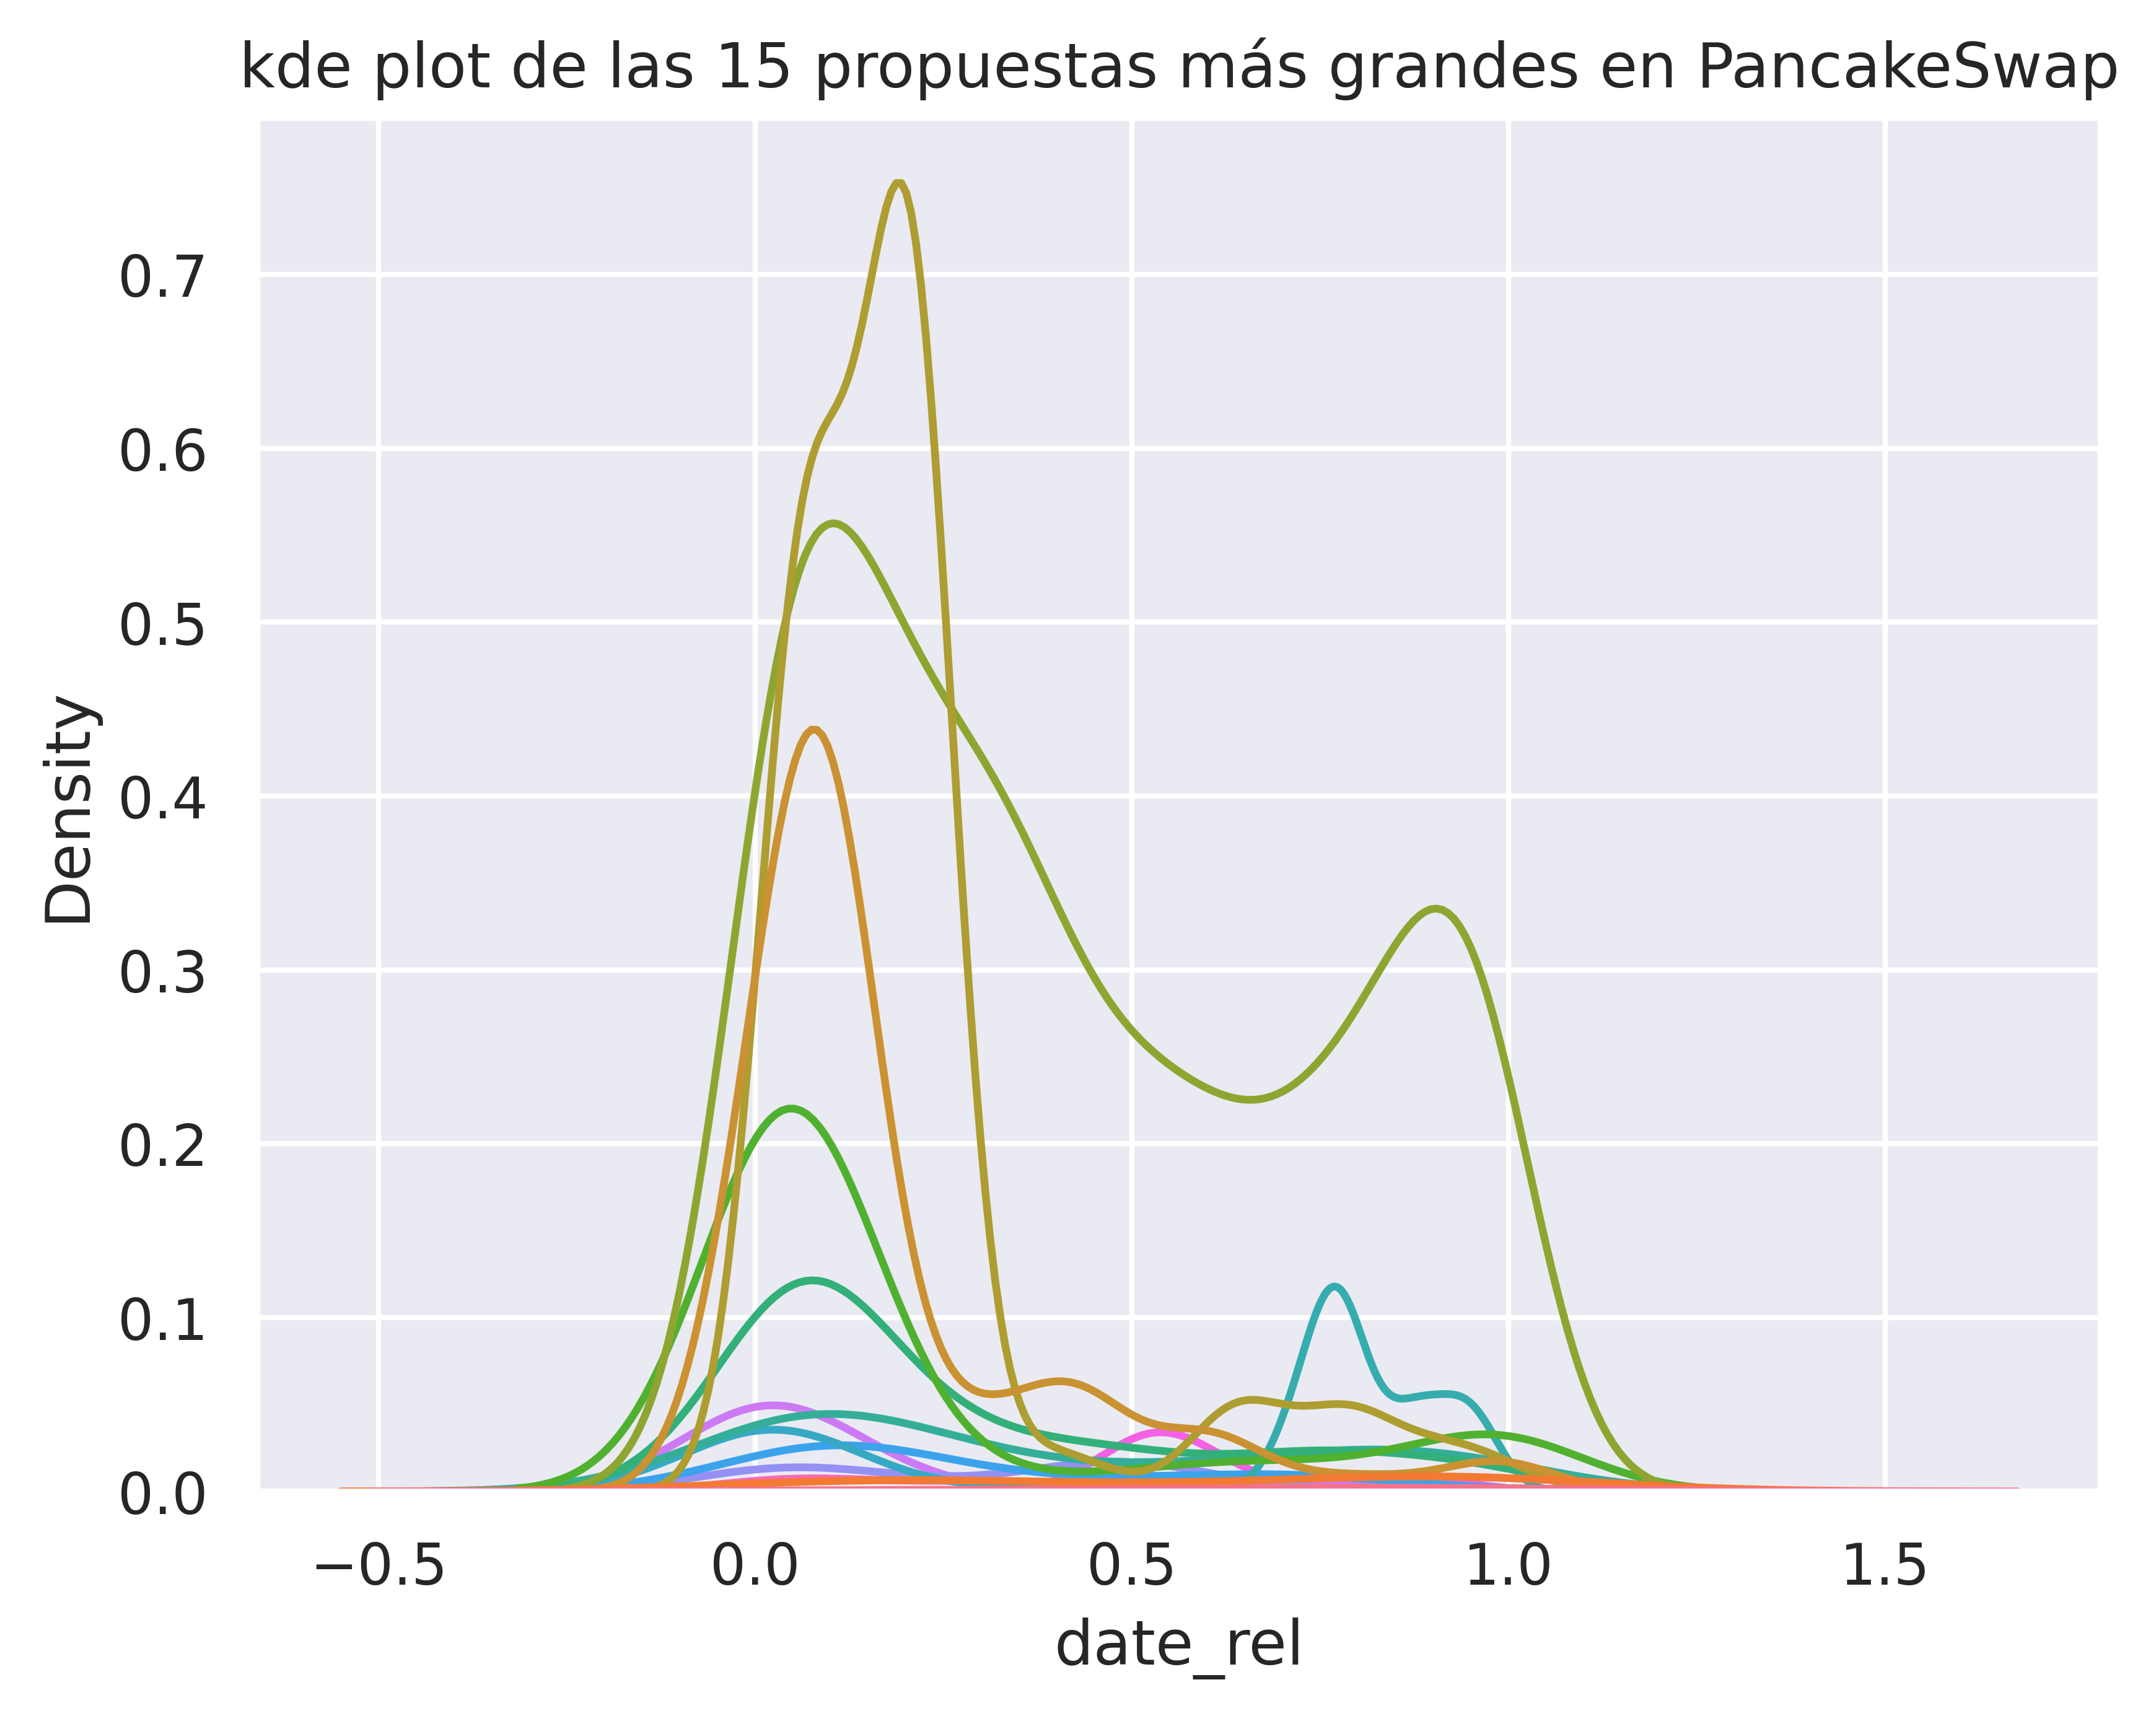

In [26]:
# Get N random proposals
# proposals = np.random.choice(_dfv2['proposal'].unique(), 15, replace=False, p=_dfv2.groupby('proposal').size() / _dfv2.groupby('proposal').size().sum())

# Get top N proposals
proposals = _dfv2.groupby('proposal').size().tail(15).index

_toplot = _dfv2[_dfv2['proposal'].isin(proposals)].copy()
_toplot['proposal'] = _toplot['proposal'].astype(str)
assert _toplot['proposal'].nunique() == len(proposals)
sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")

Efectivamente, los votos se realizan sobre todo nada más crearse la propuesta. El 25% de los votos ya han sido emitidos cuando aún queda un 95% del tiempo restante, y solo un 22% votan en la segunda mitad del tiempo disponible. Sin embargo, como podemos observar en la figura de `[kde plot de las 15 propuestas más grandes]`, hay propuestas en las que al final puede haber un pequeño repunte de actividad. Recordemos que en las DAOs el resultado de la votación es siempre visible, lo que puede sesgar la participación si los usuarios piensan que el resultado es estable y no va a cambiar.

Al partir el dataset en puntos aleatorios considerando una distribución uniforme, lo más seguro es que nos encontremos que las propuestas con las que entrenamos y testeamos (las _frontera_), tengan, en general más votos en el conjunto de entrenamiento que en el de test. Por esta razón también es necesario un sistema que sea muy resiliente al problema de cold start.